<h1 style="color:#3295ec;"><center>بسم الله الرحمن الرحيم</center></h1>

<h3 style="color:#3295ec;"><center>پروژه‌ی نهایی درس شناسایی الگو - بهار 97</center></h3>
<h4 style="color:#3295ec;"><center>استاد راهنما: جناب آقای دکتر محمدی</center></h4>
<p style="text-align: right;">نام و نا‌خانوادگی ارائه‌دهندگان:</p>
<li>
مژده احرابی تبریز 96722216 - 25 درصد
</li>
<li>
بتول سعیدی ابواسحاقی 96722108 - 25 درصد
</li>
<li>
فرزانه فخریان 96725008 - 25 درصد
</li>
<li>
هما نصیری 96722207 - 25 درصد
</li>

In [1]:
import csv
import h5py
import argparse
import numpy as np
import pandas as pd
import scipy.io as sci
from sklearn import svm
from pprint import pprint
from sklearn import metrics
from sklearn import datasets
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.preprocessing import Imputer
from sklearn.model_selection import KFold
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.utils.class_weight import compute_sample_weight

<h2 style="color:#3295ec;text-align: right;">بخش 1: بارگذاری داده</h2>
<p style="text-align: right;font-size:15px; margin-right: 10%;direction:rtl;">
پیش از هرچیز، ابتدا داده را بارگذاری می‌کنیم و سعی می‌کنیم تا ابعاد و شکل ماتریس‌ها را به دست‌آوریم
</p>

In [2]:
file = h5py.File('../Data/LabeledData.h5', 'r')
train_labels = file["labels"][0, ...]
train = np.transpose(file["features"][...])
imgIndices = file["imgIndices"][0, ...]

In [3]:
group_unique, group_cardinality = np.unique(imgIndices, return_counts=True)
print('Unique images in dataset: \n', group_unique)
print('Number of objects in each image: \n', group_cardinality)

Unique images in dataset: 
 [   5    9   11   13   17   19   21   23   27   29   33   35   47   49
   60   80  140  160  180  320  340  400  420  500  520  540  560  680
  700  720  760  820  840  920 1020 1040]
Number of objects in each image: 
 [ 836  260  424   74  683 1481 1539   24  287  131 2840  341  863  738
  335   24   15 1939  994  209  861   37   10   96  241 1322  561  257
    3  502   10  202    8  187   74  108]


<h2 style="color:#3295ec;text-align: right;">بخش 2: پیش‌پردازش</h2>
<p style="text-align: right;font-size:15px; margin-right: 10%;direction:rtl;">
پیش از شروع آموزش لازم است تا به درک درستی از داده برسیم. برای این منظور باید بتوانیم به سوالات زیر پاسخ دهیم:
</p>
<li>
آیا رده‌های مجموعه‌داده نامتوازن است؟
</li>
<li>
آیا ویژگی‌های موجود در مجموعه‌داده دارای مقادیر بی‌نهایت یا غیرعددی هست؟
</li>
<li>
آیا مجموعه‌داده تنک است؟
</li>
<li>
آیا داده نویز دارد؟
آیا داده شامل نقاط پرت است؟
</li>
<li>
آیا تمامی ویژگی‌ها لازم هستند؟ چه تعداد ویژگی مناسب است؟
</li>
<li>
آیا داده دارای تکرار هست؟
</li>

<h2 style="color:#3295ec;text-align: right;">بخش 2-1: تشخیص توازن کلاس‌های مجموعه داده</h2>
<p style="text-align: right;font-size:15px; margin-right: 10%;direction:rtl;">
برای این منظور بایست ابتدا تعداد مشاهدات از هر کلاس را به دست بیاوریم. درصورتی عدم برابری این مقدار برای دو کلاس، داده غیرمتوازن بوده و در پیش‌پردازش‌های آتی بر روی داده باید فرایندی مناسب لحاظ گردد.</p>

In [4]:
labels_unique, labels_count = np.unique(train_labels, return_counts=True)
print('Labels: ', labels_unique, '\n Repetition of each label: ', labels_count)

Labels:  [0 1] 
 Repetition of each label:  [16852  1664]


<p style="text-align: right;font-size:15px; margin-right: 10%;direction:rtl;">
برای نمایش عدم توازن در رده‌های داده که در بالا قابل مشاهده است، در آینده از یک مدل استفاده خواهیم کرد و نمودار عدم توازن را رسم خواهیم نمود. 

</p>

<h2 style="color:#3295ec;text-align: right;">بخش 2-2: حذف ویژگی‌های با مقدار بی‌نهایت یا غیرعددی</h2>
<p style="text-align: right;font-size:15px; margin-right: 10%;direction:rtl;">
در اینجا سعی می‌کنیم در صورت وجود مقادیر غیرعددی و بی‌نهایت آن‌ها را از ویژگی‌ها حذف نموده و با توجه به یک سیاست مناسب با مقدار مناسبی جایگزین نماییم.
</p>

In [5]:
from sklearn.utils import check_array
check_nan_inf = check_array(train, force_all_finite=True)

ValueError: Input contains NaN, infinity or a value too large for dtype('<f4').

<p style="text-align: right;font-size:15px; margin-right: 10%;direction:rtl;">
همان‌طور که مشاهده می‌شود ورودی شامل مقادیر بی‌نهایت یا غیرعددی است پس با استفاده از متد پیش‌پردازش به همین منظور ویژگی‌های غیرعددی یا بی‌نهایت را با جایگزین کردن مقدار میانگین هر سطر حذف می‌کنیم.
</p>

In [6]:
from sklearn.preprocessing import Imputer
from sklearn.utils import check_array

pure_data = Imputer(missing_values='NaN', strategy='mean', axis=0).fit_transform(train)
check_nan_inf = check_array(pure_data, force_all_finite=True)

if len(check_nan_inf) != 0:
    print('Data features has no more nan or inf value.')
else:
    print('Check the purity of data again!!!')

Data features has no more nan or inf value.


<h2 style="color:#3295ec;text-align: right;">بخش 2-3: تشخیص تنک بودن ماتریس داده‌ها</h2>
<p style="text-align: right;font-size:15px; margin-right: 10%;direction:rtl;">

</p>

In [7]:
check_sparsity = check_array(pure_data, accept_sparse=False)

if len(check_sparsity) != 0:
    print('Data features are not sparse.')
else:
    print('Data is a sparse matrix!!!')

Data features are not sparse.


<p style="text-align: right;font-size:15px; margin-right: 10%;direction:rtl;">
با توجه به اینکه داده تنک نیست، استفاده از روش‌هایی که برای داده تنک مطرح می‌شود، نمی‌توانیم استفاده کنیم.
</p>

<h2 style="color:#3295ec;text-align: right;">بخش 2-4: نویز و داده‌ی پرت</h2>
<p style="text-align: right;font-size:15px; margin-right: 10%;direction:rtl;">
با توجه به اینکه به جای داشتن عکس‌ها ویژگی‌های استخراج شده از اشیا آن‌ها را در اختیار داریم، برای از بین بردن تاثیر احتمالی نویز بر ویژگی‌ها و هم‌چنین مقیاس‌کردن داده به منظور از بین تاثیر داده‌ی پرت، از متدی برای این منظور در کتابخانه‌ی اس‌کا‌لرن بهره می‌بریم
</p>

In [7]:
from sklearn.preprocessing import QuantileTransformer

noise_outlier_vanishing = QuantileTransformer(output_distribution='uniform').fit_transform(pure_data, train_labels)

In [8]:
from sklearn.preprocessing import StandardScaler

standard_scaler = StandardScaler().fit_transform(pure_data, train_labels)

<p style="text-align: right;font-size:15px; margin-right: 10%;direction:rtl;">
از آن‌جایی که برخی از رده‌بندها نسبت به اندازه مقادیر حساس هستند بنابراین لازم است تا آن‌ها را در یک مقیاس مشخص نگاشت کنیم 
</p>

<h2 style="color:#3295ec;text-align: right;">بازنمایی داده‌های نامتوازن پس از انجام پیش‌پردازش‌های اولیه</h2>

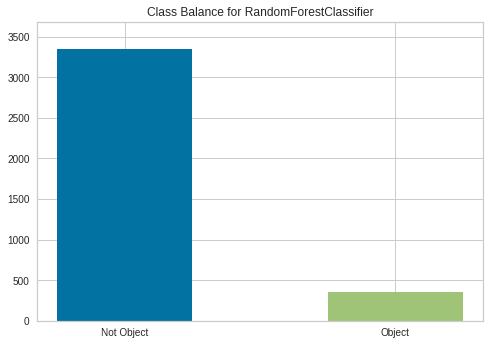

In [10]:
from yellowbrick.classifier import ClassBalance
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

X_train, X_test, y_train, y_test = train_test_split(standard_scaler, train_labels, test_size=0.2)
classes = ['Not Object', 'Object']

forest = RandomForestClassifier()
visualizer = ClassBalance(forest, classes=classes)
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
g = visualizer.poof()

<h2 style="color:#3295ec;text-align: right;">بخش 2-5: کاهش ابعاد ویژگی‌ها</h2>
<p style="text-align: right;font-size:15px; margin-right: 10%;direction:rtl;">
با توجه به اینکه تعداد ویژگی‌ها برای هر شی زیاد است بایستی ویژگی‌ها را به حدی کم کنیم که هم‌چنان بخش مورد نظر از داده حفظ شده و پس از حذف بتواند نماینده‌ی داده باشد.
</p>

<h2 style="color:#3295ec;text-align: right;">بخش 2-5-1: استفاده از تحلیل مولفه‌های اصلی</h2>
<p style="text-align: right;font-size:15px; margin-right: 10%;direction:rtl;">
ابتدا با بهره بردن از پی‌سی‌ای به نحوی که حداقل 96 درصد داده حفظ شود به یافتن بهترین تعداد کامپوننت برای تغییر فضای ویژگی اقدام شد. ولیکن به دلیل اینکه ابعاد به دست آمده‌ی جدید نیز هم‌چنان زیاد بود، و بر روی سیستم حاضر توانایی محاسباتی نداشت، می‌خواهیم روش دیگر ال‌دی‌ای را نیز مورد بررسی قرار دهیم.
</p>

In [16]:
from sklearn.decomposition import PCA

number_of_components = 2000
eigen_value_cum_sum = 0
while eigen_value_cum_sum < 0.96:
    pca_obj = PCA(n_components=number_of_components).fit(noise_outlier_vanishing)
    reduced_train_pca = pca_obj.transform(noise_outlier_vanishing)
    eigen_value_cum_sum = pca_obj.explained_variance_ratio_.cumsum()[-1]
    print('Number of PC\'s: {0:>6}, Cumulative sum: {1:>6}'.format(number_of_components, eigen_value_cum_sum))
    number_of_components += 100

Number of PC's:   2000, Cumulative sum: 0.9451602101325989
Number of PC's:   2100, Cumulative sum: 0.9491404294967651
Number of PC's:   2200, Cumulative sum: 0.9528445601463318
Number of PC's:   2300, Cumulative sum: 0.9562956094741821
Number of PC's:   2400, Cumulative sum: 0.9595005512237549
Number of PC's:   2500, Cumulative sum: 0.9624894857406616


In [27]:
pca_number = []
cum_sum = []
number_of_components = 10
while number_of_components < 100:
  pca = PCA(n_components=number_of_components).fit(train_set)
  reduced_train_pca = pca.transform(train_set)
  eigen_value_cum_sum = pca.explained_variance_ratio_.cumsum()[-1]
  print("Number of PCA: ", number_of_components, ", ",  "Cumulative sum: ", eigen_value_cum_sum)
  pca_number.append(number_of_components)
  cum_sum.append(eigen_value_cum_sum)
  number_of_components += 10

Number of PCA:  10 ,  Cumulative sum:  0.5631955
Number of PCA:  20 ,  Cumulative sum:  0.61363715
Number of PCA:  30 ,  Cumulative sum:  0.64192843
Number of PCA:  40 ,  Cumulative sum:  0.661593
Number of PCA:  50 ,  Cumulative sum:  0.6760208
Number of PCA:  60 ,  Cumulative sum:  0.6876368
Number of PCA:  70 ,  Cumulative sum:  0.6972664
Number of PCA:  80 ,  Cumulative sum:  0.7055185
Number of PCA:  90 ,  Cumulative sum:  0.71273416


In [28]:
print ("cum_sum: ", cum_sum)

cum_sum:  [0.5631955, 0.61363715, 0.64192843, 0.661593, 0.6760208, 0.6876368, 0.6972664, 0.7055185, 0.71273416]


In [ ]:
eigen_value_cum_sum = 0
number_of_components = 100
while eigen_value_cum_sum < 0.97:
  pca = PCA(n_components=number_of_components).fit(train_set)
  reduced_train_pca = pca.transform(train_set)
  eigen_value_cum_sum = pca.explained_variance_ratio_.cumsum()[-1]
  pca_number.append(number_of_components)
  cum_sum.append(eigen_value_cum_sum)
  number_of_components += 100

In [35]:
for i in range(len(pca_number)):
  print("Number of PCA Component: ", pca_number[i], ", ",  "Cumulative sum: ", cum_sum[i])

Number of PCA Component:  10 ,  Cumulative sum:  0.5631955
Number of PCA Component:  20 ,  Cumulative sum:  0.61363715
Number of PCA Component:  30 ,  Cumulative sum:  0.64192843
Number of PCA Component:  40 ,  Cumulative sum:  0.661593
Number of PCA Component:  50 ,  Cumulative sum:  0.6760208
Number of PCA Component:  60 ,  Cumulative sum:  0.6876368
Number of PCA Component:  70 ,  Cumulative sum:  0.6972664
Number of PCA Component:  80 ,  Cumulative sum:  0.7055185
Number of PCA Component:  90 ,  Cumulative sum:  0.71273416
Number of PCA Component:  100 ,  Cumulative sum:  0.7191869
Number of PCA Component:  200 ,  Cumulative sum:  0.76184183
Number of PCA Component:  300 ,  Cumulative sum:  0.7883191
Number of PCA Component:  400 ,  Cumulative sum:  0.80870605
Number of PCA Component:  500 ,  Cumulative sum:  0.82563674
Number of PCA Component:  600 ,  Cumulative sum:  0.8402553
Number of PCA Component:  700 ,  Cumulative sum:  0.8531741
Number of PCA Component:  800 ,  Cumulative 

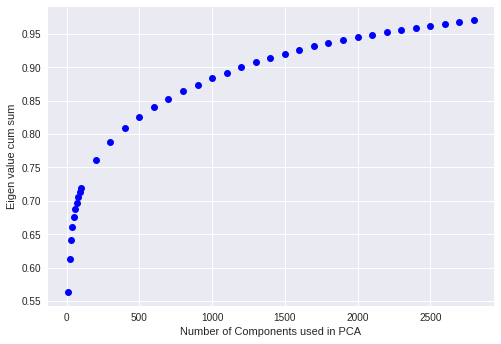

In [32]:
_timport matplotlib.pyplot as plt
plt.xlabel("Number of Components used in PCA")
plt.ylabel("Eigen value cum sum")
plt.plot(pca_number, cum_sum, 'bo')

<p style="text-align: right;font-size:15px; margin-right: 10%;direction:rtl;">
همانطور که مشاهده می‌شود و انتظار داشتیم، با افزایش تعداد مولفه‌ها، سرعت رشد تابع انرژی کاهش پیدا می‌کند. برای تعداد مولفه 2500، مقدار تابع انرژی به حدود 96% می‌رسد.
دلیل اینکه سرعت رشد کاهش پیدا می‌کند این است که با افزایش تعداد مولفه‌ها، همبستگی بین ویژگی‌ها افزایش پبدا می‌کند. استفاده از تمام مولفه‌ها برای آموزش مدل، مناسب نیست. به دلیل افزایش همبستگی بین ویژگی‌ها افزایش پیدا می‌کند. همچنین ممکن است که ویژگی‌ها نویز داشته باشند و استفاده از آنها در طبقه‌بندی دقت را روی داده تست کاهش می‌دهد.
برای اینکه نتیجه خوبی روی داده تست داشته باشیم، باید تلاش کنیم مقدار بهینه را برای تعداد مولفه‌ها پیدا کنیم. جایی که دقت روی داده تست به مقدار بیشینه خود می‌رسد و پس از آن دقت کاهش پیدا می‌کند.
</p>

<h2 style="color:#3295ec;text-align: right;">بخش 2-5-2: استفاده از ال‌دی‌ای برای کاهش ابعاد داده</h2>
<p style="text-align: right;font-size:15px; margin-right: 10%;direction:rtl;">
ابتدا با بهره بردن از پی‌سی‌ای به نحوی که حداقل 96 درصد داده حفظ شود به یافتن بهترین تعداد کامپوننت برای تغییر فضای ویژگی اقدام شد. ولیکن به دلیل اینکه ابعاد به دست آمده‌ی جدید نیز هم‌چنان زیاد بود، و بر روی سیستم حاضر توانایی محاسباتی نداشت، می‌خواهیم روش دیگر ال‌دی‌ای را نیز مورد بررسی قرار دهیم.
</p>

In [43]:
from sklearn.decomposition import PCA

number_of_components = 500
pca = PCA(n_components=number_of_components).fit(noise_outlier_vanishing)
reduced_train_pca = pca.transform(noise_outlier_vanishing)
eigen_value_cum_sum = pca.explained_variance_ratio_.cumsum()[-1]
print('Number of PC\'s: {0:>6}, Cumulative sum: {1:>6}'.format(number_of_components, eigen_value_cum_sum))

Number of PC's:    500, Cumulative sum: 0.8256332278251648


<p style="text-align: right;font-size:15px; margin-right: 10%;direction:rtl;">
به دلیل طولانی بودن محاسبات فوق به صورت هیورستیک بازه‌ی مورد نظر برای تعداد کامپوننت‌ها را تعیین کرده و برای حفظ حداقل 0.96 درصد از فضای داده تعداد مولفه‌ها برابر ۲۵۰۰ تعیین پیدا شد ولی به دلیل محدودیت محاسباتی 2500 کامپوننت از 500 مولفه استفاده می‌کنیم و که برای پرهیز از محاسبات مجدد ذخیره شده و درصورت لزوم از بارگذاری مجدد مولفه‌های اصلی به دست آمده استفاده خواهد شد.
</p>

In [44]:
reduced_train_pca_df = np.hstack((reduced_train_pca, train_labels.reshape((18516,1))))
train_data_frame = pd.DataFrame(reduced_train_pca_df, columns=['PCA%i' % i for i in range(number_of_components)]+['target_value'])
train_data_frame.to_csv('../PCA/pca_p_500.csv', sep='\t')

In [45]:
number_of_components = 500
loaded_pca_df = pd.DataFrame.from_csv('../PCA/pca_p_500.csv', sep='\t')
columns = ['PCA%i' % i for i in range(number_of_components)]
loaded_train_pca = np.array(loaded_pca_df[columns])
y_true = loaded_pca_df['target_value']
print((y_true == train_labels).all())

/home/hgirlwxx/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  


True


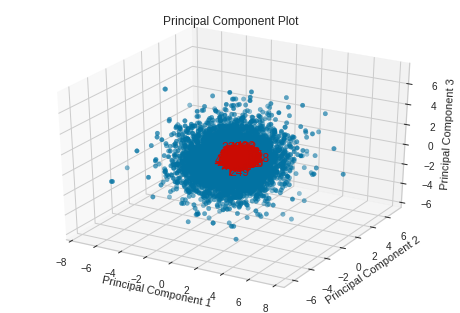

In [46]:
from yellowbrick.features.pca import PCADecomposition

features = columns
visualizer = PCADecomposition(scale=True, proj_features=True, proj_dim=3)
visualizer.fit_transform(loaded_train_pca, train_labels)
visualizer.poof()

<h2 style="color:#3295ec;text-align: right;">بخش 2-5-3: استفاده از تحلیل جداساز خطی</h2>
<p style="text-align: right;font-size:15px; margin-right: 10%;direction:rtl;">
با توجه به اینکه مسئله‌ی پیش‌رو رده‌بندی است می‌توان نتیجه‌ی جداساز خطی برای کاهش بعد را نیز مورد بررسی قرار داد. البته با توجه به اینکه این روش تعداد مولفه‌های موثرش کمتر از تعداد کلاس‌ها منهای یک است، تعداد مولفه‌ها برای این مسئله ۱ خواهد بود و تمام ویژگی‌ها را به یک محور نگاشت خواهد کرد.
</p>

In [48]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

number_of_lda_components = 2
lda_obj = LinearDiscriminantAnalysis(n_components=number_of_lda_components, solver='svd', tol=0.0001).fit(noise_outlier_vanishing, train_labels)
reduced_train_lda = lda_obj.transform(noise_outlier_vanishing)
cumulative_sum_lda = lda_obj.explained_variance_ratio_.cumsum()
print('Number of PC\'s: {0:>6}, Cumulative sum: {1:>6}'.format(number_of_lda_components, cumulative_sum_lda[-1]))
print(cumulative_sum_lda)

/home/hgirlwxx/.local/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


Number of PC's:      2, Cumulative sum:    1.0
[1.]


Text(0.5,1,'LDA of Labeled dataset (SVD)')

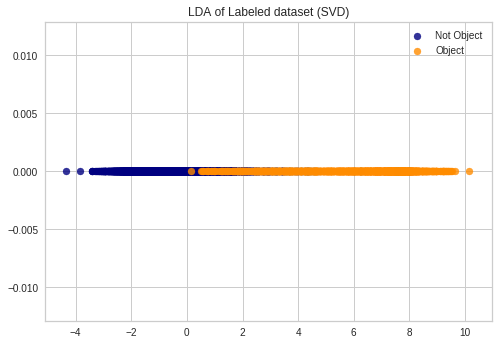

In [50]:
colors = ['navy', 'darkorange']
for color, i, target_name in zip(colors, [0, 1], ['Not Object', 'Object']):
    y_plt = np.zeros(shape=(reduced_train_lda[train_labels == i, 0].shape))
    plt.scatter(reduced_train_lda[train_labels == i, 0], y_plt, alpha=.8, color=color, label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('LDA of Labeled dataset (SVD)')

In [32]:
lda_eigen = LinearDiscriminantAnalysis(n_components=2, shrinkage='auto', solver='eigen')
x_lda = lda_eigen.fit_transform(noise_outlier_vanishing, train_labels)
print(lda_eigen.explained_variance_ratio_)

[0.00156437]


Text(0.5,1,'LDA of Labeled dataset (eigen)')

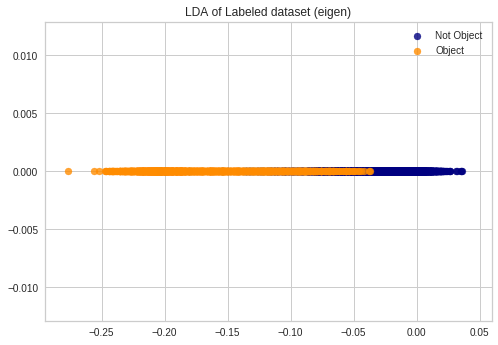

In [36]:
colors = ['navy', 'darkorange']
for color, i, target_name in zip(colors, [0, 1], classes):
    y_plt = np.zeros(shape=(x_lda[train_labels == i, 0].shape))
    plt.scatter(x_lda[train_labels == i, 0], y_plt, alpha=.8, color=color, label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('LDA of Labeled dataset (eigen)')

<p style="text-align: right;font-size:15px; margin-right: 10%;direction:rtl;">
همان‌طور که مشاهده می‌شود به دلیل اینکه تعداد کلاس‌های مسئله دو است ال‌دی‌ای بیشتر از یک مولفه را نگه نخواهد داشت و ضمن تلاش برای حفظ فاصله بین دو کلاس، دو کلاس تداخل دارند.
</p>

<h2 style="color:#3295ec;text-align: right;">بخش 2-5-4: استفاده از کاهش بعد ایزومپ</h2>
<p style="text-align: right;font-size:15px; margin-right: 10%;direction:rtl;">
تلاش شد تا با استفاده از ایزومپ نیز کاهش ابعاد داده مورد بررسی قرار بگیرد ولیکن به دلیل حجم محاسبات بالا، با خطای پر شدن حافظه روبه‌رو شده و مورد استفاده قرار نگرفت.
</p>

In [26]:
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from yellowbrick.features.manifold import Manifold

model = Pipeline([
    ("selectk", SelectKBest(k=3, score_func=f_classif)),
    ("viz", Manifold(manifold='isomap', target='discrete')),
])

model.fit(train_stdPCA, train_labels)
model.named_steps['viz'].poof()

MemoryError: 

<h2 style="color:#3295ec;text-align: right;">بخش 2-6: حذف داده تکراری</h2>
<p style="text-align: right;font-size:15px; margin-right: 10%;direction:rtl;">
برای این منظور بر روی دیتافریم داده پس از اعمال تحلیل مولفه‌های اصلی با فراخوانی متد حذف تکراری‌ها، سطرهای تکراری را حذف می‌کنیم
</p>

In [45]:
deduplicated_pca_df = loaded_pca_df.drop_duplicates(keep='first')
if loaded_pca_df.shape == deduplicated_pca_df.shape:
    print('There is no row with its corresponding label which is duplicated!')

There is no row with its corresponding label which is duplicated!


In [46]:
def remove_duplicate(a, b):
    row_label = dict()
    for i in range(len(a)):
        row = str(a[i])
        label = b[i]
        if row not in row_label.keys():
            row_label[row] = [a[i], dict()]
            if label not in row_label[row][1].keys():
                row_label[row][1][label] = 1
        else:
            if label not in row_label[row][1].keys():
                row_label[row][1][label] = 1
            else:
                row_label[row][1][label] += 1
    final_list = []
    final_label =[]

    for key in row_label:
        class_counts = row_label[key][1]
        if len(class_counts.keys()) == 2:
            if class_counts[0] > class_counts[1]:
                final_list.append(row_label[key][0])
                final_label.append(0)
            elif class_counts[0] < class_counts[1]:
                final_list.append(row_label[key][0])
                final_label.append(1)
        else:
            final_list.append(row_label[key][0])
            final_label.append(list(class_counts.keys())[0])
    return np.array(final_list), np.array(final_label)

In [50]:
r1, r2 = remove_duplicate(loaded_train_pca, train_labels)
if r1.shape[0] == r2.shape[0]:
    print('There is no row duplicated with noisy labels!')

There is no row duplicated with noisy labels!


<h2 style="color:#3295ec;text-align: right;">بخش 3: متوازن کردن داده</h2>
<p style="text-align: right;font-size:15px; margin-right: 10%;direction:rtl;">
باتوجه به اینکه داده نامتوازن است و کلاس اکثریت کلاس منفی بوده بنابراین با استفاده از روش اسموت داده را بالانس می‌کنیم.
برای تقسیم داده‌ها به تست و آموزش، قسمتی از داده را برای تست کنار می‌گذاریم که مدل آموزش داده شده را بر روی دادگان تست ارزیابی کنیم.
دادگان آموزشی را با استفاده از اسموت متوازن می‌کنیم. بدین صورت که برای دادگان با کلاس کمتر، داده جدید تولید می‌شود.
</p>

In [37]:
from sklearn.model_selection import GroupShuffleSplit
from imblearn.over_sampling import SMOTE

iter = 0
def get_balanced_train_data(X, y, groups):
        gss = GroupShuffleSplit(n_splits=4, test_size=0.2, random_state=42)
        global iter
        step = -1
        X_train, y_train = None, None
        X_test, y_test = None, None
        balanced_X_train, balanced_y_train = None, None
        for i, j in gss.split(X, y, groups):
            if (step + 1) == iter:
                X_train, y_train = X[i], y[i]
                X_test, y_test = X[j], y[j]
                balanced_X_train, balanced_y_train = SMOTE(random_state=42).fit_sample(X_train, y_train)
                break
            step += 1
        iter += 1
        result = {'x_train': balanced_X_train, 'y_train': balanced_y_train, 'x_test': X_test, 'y_test': y_test}
        return result

In [40]:
result = get_balanced_train_data(loaded_train_pca, train_labels, imgIndices)
x_train = result['x_train']
y_train = result['y_train']
x_test = result['x_test']
y_test = result['y_test']

<h2 style="color:#3295ec;text-align: right;">بخش 4: بررسی رده‌بندها</h2>
<p style="text-align: right;font-size:15px; margin-right: 10%;direction:rtl;">
برای آموزش رده‌بندها داده را به دو بخش آموزش و تست به گونه‌ای تقسیم می‌کنیم که داده تست در هیچ بازه‌ای از آموزش مورد استفاده قرار نگیرد و تنها به عنوان ارزیابی نهایی از آن استفاده شده‌است.
تمامی داده‌های تست از یک دسته عکس انتخاب شده‌اند.
از بخش 4-1 تا 4-5 آموزش بر روی داده‌ی نامتوازن بوده و از بخش 4-6 به بعد آموزش بر روی داده‌ی بالانس بوده‌است.
</p>

<h2 style="color:#3295ec;text-align: right;">بخش 4-0-1:</h2>
<p style="text-align: right;font-size:15px; margin-right: 10%;direction:rtl;">
مدل‌های اولیه با استفاده از ۱۰۰ مولفه اصلی آموزش داده شده‌اند.
</p>

In [35]:
from sklearn.decomposition import PCA

pca_std100 = PCA(n_components=100).fit(train_std)
train_stdwPCA100 = pca_std100.transform(train_std)

<h2 style="color:#3295ec;text-align: right;">بخش 4-0-2:</h2>
<p style="text-align: right;font-size:15px; margin-right: 10%;direction:rtl;">
یک بخش از داده را بر اساس برچسب تصاویر به عنوان داده‌ی تست کلی خارج کرده و مابقی را به عنوان داده‌ی آموزشی برای ارزیابی متقابل و آموزش مدل استفاده می‌کنیم.
داده‌ای که برای تست جدا شده‌است در هیچ زمانی در مراحل آموزش استفاده نشده‌است.
</p>

In [36]:
from sklearn.model_selection import LeavePGroupsOut

kgf = LeavePGroupsOut(4)

for i, j in kgf.split(train_stdwPCA100, groups=imgIndices):
    x_train1, x_test1 = train_stdwPCA100[i], train_stdwPCA100[j]
    y_train1, y_test1 = train_labels[i], train_labels[j]
    train_group, test_group = images_groups[i], images_groups[j]
    break

<h2 style="color:#3295ec;text-align: right;">بخش 4-0-3:</h2>
<p style="text-align: right;font-size:15px; margin-right: 10%;direction:rtl;">
برای مقایسه‌ی پیش‌بینی کلاس بر اساس داده‌ی متوازن و غیر متوازن، یک نسخه‌ی متوازن از داده‌های آموزش مرحله قبل را با استفاده از روش SMOTE نمونه‌برداری رو به بالا کرده‌ایم.
</p>

In [37]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=45)
x_1, y_1 = sm.fit_sample(x_train1, y_train1)


<h2 style="color:#3295ec;text-align: right;">بخش 4-0-4:</h2>
<p style="text-align: right;font-size:15px; margin-right: 10%;direction:rtl;">
پیش از بررسی رده‌بندهای متفاوت، ابتدا نایو بیز را مورد بررسی قرار دادیم. ولیکن به دلیل نامتوازن بودن داده و وجود ویژگی‌هایی که موجب تداخل توزیع هر کلاس شده، دقت این رده‌بند مناسب نبوده‌است.
</p>

In [46]:
from sklearn.naive_bayes import GaussianNB

GNB_clf = GaussianNB()
GNB_clf.fit(x_,y_)

trainpredGNB=GNB_clf.predict(x_)
testpredGNB=GNB_clf.predict(x_test)

print(metrics.f1_score(y_, trainpredGNB))
print(metrics.f1_score(y_test, testpredGNB))

# #GNB_acc = cross_val_score(GNB_clf, train_normalized, train_labels, cv=10, scoring='accuracy')

# print(GNB_acc)
# print(np.mean(GNB_acc))


0.634858577083
0.385228095583


<h2 style="color:#3295ec;text-align: right;">بخش 4-1: KNNClassifier</h2>

In [31]:
from sklearn.neighbors import KNeighborsClassifier

accs=[]
ks=[]
for k in range (1,30):
    Tknn=KNeighborsClassifier(n_neighbors=k)
    acc=cross_val_score(Tknn, x_train, y_train, cv=10, scoring='f1_weighted')
    accs.append(acc.mean())
    ks.append(k)

print('Best K value in KNN with Max F1-Measure is :',(accs.index(max(accs))+1))
print('Best F1-Measure : ', max(accs))

best_k = accs.index(max(accs))+1

Best K value in KNN with Max F1-Measure is : 5
Best F1-Measure :  0.9581809861757314


In [32]:
from sklearn.neighbors import KNeighborsClassifier
#use best K for knn
knn=KNeighborsClassifier(n_neighbors=best_k).fit(x_train,y_train)
acc2=cross_val_score(knn, x_train, y_train, cv=10, scoring='f1_weighted')

testpred=knn.predict(x_test)

print(acc2)
print(np.mean(acc2))

print(metrics.accuracy_score(y_test, testpred))

[0.95857566 0.95385873 0.96273369 0.9494768  0.96599155 0.95300027
 0.96318042 0.95421796 0.96055262 0.96022216]
0.9581809861757314
0.9570101533808598


In [49]:
knn=joblib.load('models/knn_5.pkl')

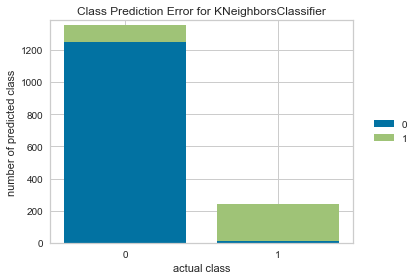

In [65]:
# Instantiate the classification model and visualizer
vis_knn = ClassPredictionError(
    knn, classes=[0,1])


# Evaluate the model on the test data
vis_knn.score(x_test1, y_test1)

# Draw visualization
g = vis_knn.poof()

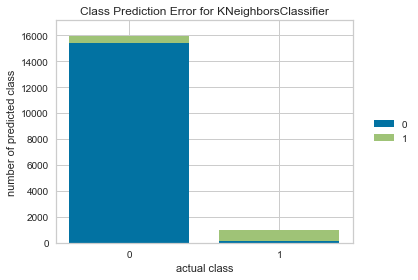

In [66]:
# Instantiate the classification model and visualizer
vis_knn = ClassPredictionError(
    knn, classes=[0,1])


# Evaluate the model on the test data
vis_knn.score(x_train1, y_train1)

# Draw visualization
g = vis_knn.poof()

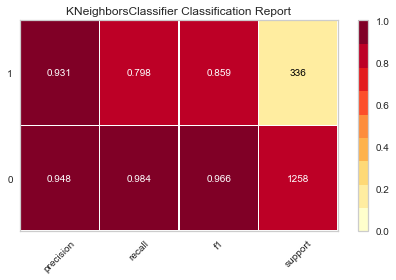

In [39]:
from yellowbrick.classifier import ClassificationReport

# Instantiate the classification model and visualizer
vis = ClassificationReport(knn, classes=[0,1],support=True)

# vis.fit(x_test, y_test)  # Fit the visualizer and the model
vis.score(x_test1, y_test1)  # Evaluate the model on the test data
g = vis.poof()             # Draw/show/poof the data

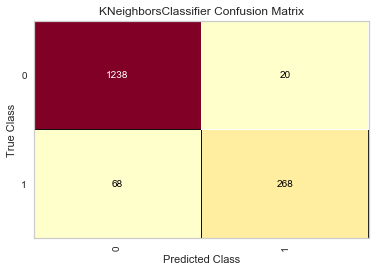

In [93]:
cm = ConfusionMatrix(knn, classes=[0,1])

cm.score(x_test1, y_test1)

cm.poof()


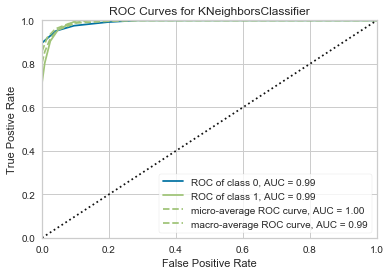

In [154]:
from yellowbrick.classifier import ROCAUC

visualizer = ROCAUC(knn5)

visualizer.score(x_test, y_test)  # Evaluate the model on the test data
g = visualizer.poof()             # Draw/show/poof the data


<h2 style="color:#3295ec;text-align: right;">بخش 4-2: Decision Tree</h2>

In [63]:
from sklearn.tree import DecisionTreeClassifier

DT_clf_2 = DecisionTreeClassifier(max_depth=20, min_samples_split=3,random_state=6, class_weight='balanced').fit(train_set,train_label_set)
DT_acc_2 = cross_val_score(DT_clf_2, train_set, train_label_set, cv=20, scoring='f1_weighted')

print(DT_acc_2)
print(np.mean(DT_acc_2))

testpred_dt_2=DT_clf_2.predict(test_set)

print(metrics.accuracy_score(test_label_set, testpred_dt_2))


[0.9419453  0.93212589 0.93118409 0.9316157  0.95334404 0.94989376
 0.91370012 0.94747432 0.94558263 0.92055576 0.93523182 0.94657626
 0.94296272 0.94563613 0.94702436 0.94337813 0.9290287  0.94842972
 0.93576691 0.94025974]
0.939085805081568
0.93799956794124


In [49]:
dt=joblib.load('models/dt_20_3_6.pkl')

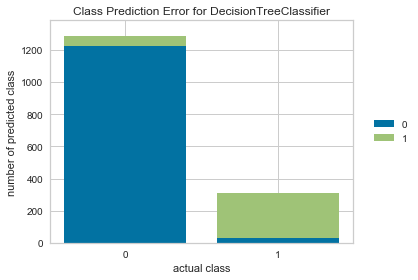

In [52]:
# Instantiate the classification model and visualizer
vis_dt = ClassPredictionError(
    dt, classes=[0,1])

# Evaluate the model on the test data
vis_dt.score(x_test1, y_test1) ## imbalanced test data

# Draw visualization
g = vis_dt.poof()

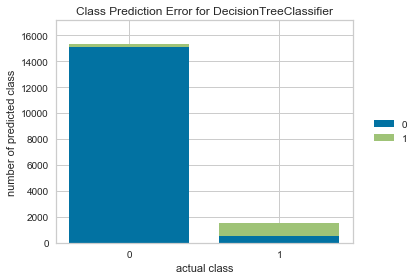

In [53]:
# Instantiate the classification model and visualizer
vis_dt = ClassPredictionError(
    dt, classes=[0,1])

# Evaluate the model on the test data
vis_dt.score(x_train1, y_train1) ## imbalanced train data

# Draw visualization
g = vis_dt.poof()

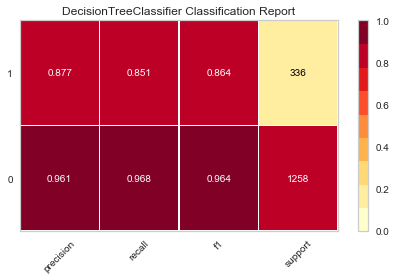

In [58]:
from yellowbrick.classifier import ClassificationReport

# Instantiate the classification model and visualizer
vis = ClassificationReport(dt, classes=[0,1],support=True)

#vis.fit(x_test1, y_test1)  # Fit the visualizer and the model
vis.score(x_test1, y_test1)  # Evaluate the model on the test data
g = vis.poof()             # Draw/show/poof the data

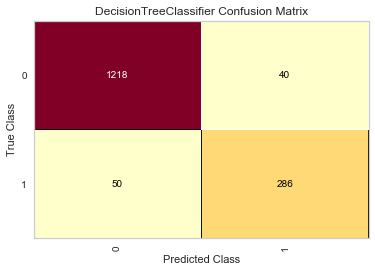

In [101]:
cm = ConfusionMatrix(dt, classes=[0,1])

cm.score(x_test1, y_test1)

cm.poof()

<h2 style="color:#3295ec;text-align: right;">نتیجه:</h2>
<p style="text-align: right;font-size:15px; margin-right: 10%;direction:rtl;">
همانطور که مشاهده می‌شود زمانی که از داده‌ی متوازن استفاده شده‌است، پیش‌بینی که در نمودار سوم قابل مشاهده‌ است، بهبود پیدا کرده‌است.</p>

<h2 style="color:#3295ec;text-align: right;">بخش 4-3: ExtraTreesClassifier</h2>

In [68]:
# ExtraTreesClassifier (10)
from sklearn.ensemble import ExtraTreesClassifier

ET_clf_2 = ExtraTreesClassifier(n_estimators=400, max_depth=30,min_samples_split=3, random_state=0, class_weight='balanced').fit(train_set, train_label_set)
ET_acc_2 = cross_val_score(ET_clf_2, train_set, train_label_set, cv=20, scoring='f1_weighted')
print(ET_acc_2)
print(np.mean(ET_acc_2))

testpred_et_2=ET_clf_2.predict(test_set)
print(metrics.accuracy_score(test_label_set, testpred_et_2))

[0.95810309 0.94391564 0.95604199 0.9436236  0.96650405 0.95976802
 0.95214786 0.96312516 0.96041387 0.94952887 0.94906062 0.97399972
 0.96009574 0.95901491 0.97021809 0.95663441 0.96399559 0.95326761
 0.95594945 0.94859996]
0.9572004132654275
0.9576582415208469


In [53]:
et1=joblib.load('models/Models/et_400_30_3.pkl')

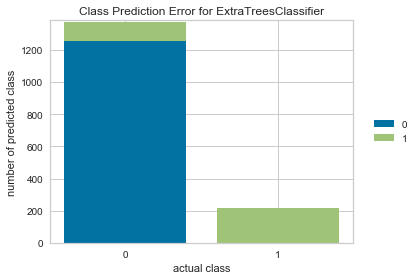

In [117]:
# Instantiate the classification model and visualizer
vis_et1 = ClassPredictionError(
    et1, classes=[0,1])

# Evaluate the model on the test data
vis_et1.score(x_test1, y_test1)

# Draw visualization
g = vis_et1.poof()

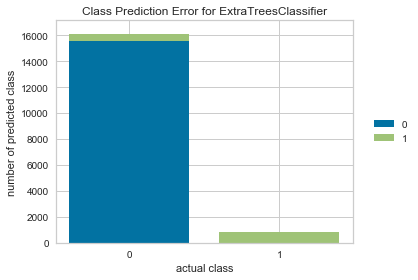

In [118]:
# Instantiate the classification model and visualizer
vis_et1 = ClassPredictionError(
    et1, classes=[0,1])

# Evaluate the model on the test data
vis_et1.score(x_train1, y_train1)

# Draw visualization
g = vis_et1.poof()

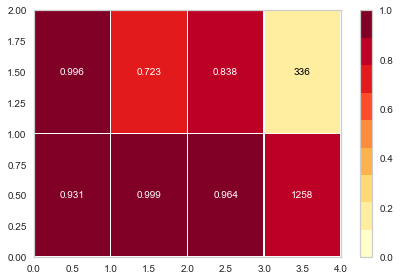

In [40]:
from yellowbrick.classifier import ClassificationReport

# Instantiate the classification model and visualizer
visxx = ClassificationReport(et1, classes=[0,1],support=True)

#vis.fit(x_test1, y_test1)  # Fit the visualizer and the model
visxx.score(x_test1, y_test1)  # Evaluate the model on the test data
g = vis.poof()             # Draw/show/poof the data

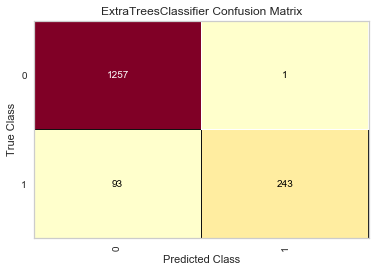

In [105]:
cm = ConfusionMatrix(et1, classes=[0,1])

cm.score(x_test1, y_test1)

cm.poof()

<h2 style="color:#3295ec;text-align: right;">بخش 4-4: GradientBoostingClassifier</h2>

In [33]:
from sklearn.ensemble import GradientBoostingClassifier

GBC_clf = GradientBoostingClassifier(n_estimators=1000, learning_rate=0.1, max_depth=1).fit(x_train, y_train)
GBC_acc=cross_val_score(GBC_clf,x_train,y_train,cv=10,scoring='f1_weighted')

testpredGBC=GBC_clf.predict(x_test)

print(metrics.accuracy_score(y_test, testpredGBC))


# print(GBC_acc)
# print(np.mean(GBC_acc))


0.9535536833009289


In [48]:
gbc=joblib.load('models/gbc.pkl')

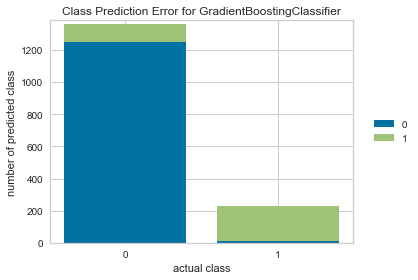

In [61]:
# Instantiate the classification model and visualizer
vis_gbc = ClassPredictionError(
    gbc, classes=[0,1])

# Evaluate the model on the test data
vis_gbc.score(x_test1, y_test1)

# Draw visualization
g = vis_gbc.poof()

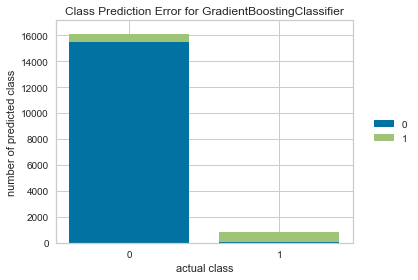

In [62]:
# Instantiate the classification model and visualizer
vis_gbc = ClassPredictionError(
    gbc, classes=[0,1])

# Evaluate the model on the test data
vis_gbc.score(x_train1, y_train1)

# Draw visualization
g = vis_gbc.poof()

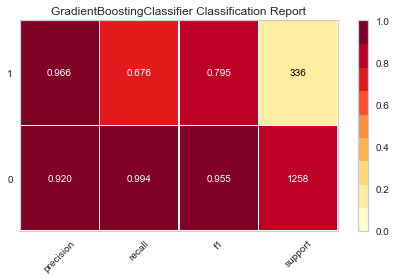

In [57]:
from yellowbrick.classifier import ClassificationReport

# Instantiate the classification model and visualizer
vis = ClassificationReport(gbc, classes=[0,1],support=True)

#vis.fit(x_test, y_test)  # Fit the visualizer and the model
vis.score(x_test1, y_test1)  # Evaluate the model on the test data
g = vis.poof()             # Draw/show/poof the data

<h2 style="color:#3295ec;text-align: right;">بخش 4-5: RandomForestClassifier</h2>
<p style="text-align: right;font-size:15px; margin-right: 10%;direction:rtl;">
به دلیل پرهیز از آموزش مجدد مدل زیر، پس از تصحیح ارسال پارامتر صحیح به متد پیش‌بینی دقت بر داده‌ی تست محاسبه شده‌است.
</p>

In [36]:
from sklearn.ensemble import RandomForestClassifier

random_forest_clf_2 = RandomForestClassifier(n_estimators=750).fit(x_train,y_train)
acc_random_forest_2 = cross_val_score(random_forest_clf_2, x_train, y_train, cv=20, scoring='f1_weighted')

print(acc_random_forest_2)
print(np.mean(acc_random_forest_2))

# trainpred=random_forest_clf.predict(train_normalized)
testpred_rf2 =random_forest_clf.predict(x_test)

print(metrics.accuracy_score(y_test, testpred_rf2))


#results.append(random_forest_clf.predict(test_normalized))

[0.95263818 0.95622526 0.94198963 0.96791975 0.94843522 0.95895309
 0.94653969 0.94202646 0.95758363 0.95263818 0.95382875 0.95029923
 0.95382875 0.96272442 0.94176842 0.9450035  0.96198423 0.96267102
 0.9551245  0.96192983]
0.9537055858623489
0.9552819183408944


In [51]:
rf2=joblib.load('models/rf2.pkl')

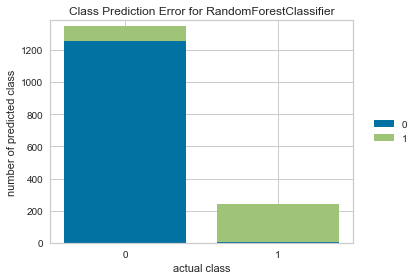

In [80]:
# Instantiate the classification model and visualizer
vis_rf2 = ClassPredictionError(
    rf2, classes=[0,1])


# Evaluate the model on the test data
vis_rf2.score(x_test1, y_test1)

# Draw visualization
g = vis_rf2.poof()

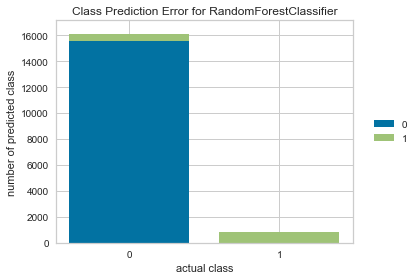

In [81]:
# Instantiate the classification model and visualizer
vis_rf2 = ClassPredictionError(
    rf2, classes=[0,1])


# Evaluate the model on the test data
vis_rf2.score(x_train1, y_train1)

# Draw visualization
g = vis_rf2.poof()

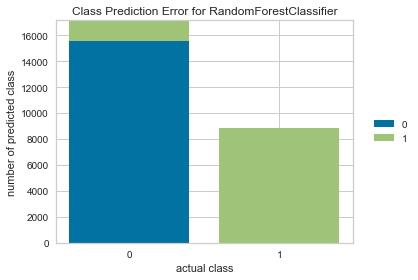

In [82]:
# Instantiate the classification model and visualizer
vis_rf2 = ClassPredictionError(
    rf2, classes=[0,1])


# Evaluate the model on the test data
vis_rf2.score(x_1, y_1)

# Draw visualization
g = vis_rf2.poof()

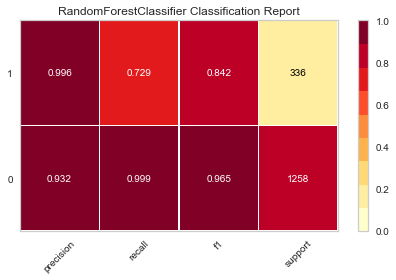

In [71]:
from yellowbrick.classifier import ClassificationReport

# Instantiate the classification model and visualizer
vis = ClassificationReport(rf2, classes=[0,1],support=True)

#vis.fit(x_test, y_test)  # Fit the visualizer and the model
vis.score(x_test1, y_test1)  # Evaluate the model on the test data
g = vis.poof()             # Draw/show/poof the data

In [34]:
from sklearn.ensemble import RandomForestClassifier

random_forest_clf = RandomForestClassifier(n_estimators=500).fit(x_train,y_train)
acc_random_forest = cross_val_score(random_forest_clf, x_train, y_train, cv=30, scoring='f1_weighted')

# trainpred=random_forest_clf.predict(train_normalized)
testpred=random_forest_clf.predict(x_test)

print(acc_random_forest)
print(np.mean(acc_random_forest))


#results.append(random_forest_clf.predict(test_normalized))

[0.95824605 0.95969957 0.94744917 0.93981716 0.95495835 0.96796556
 0.95222652 0.94650158 0.96280579 0.94650158 0.94851507 0.93267496
 0.94933827 0.96998784 0.94812075 0.94361174 0.95613607 0.94812075
 0.9548619  0.97706914 0.95531296 0.9412904  0.95186632 0.93339065
 0.95940647 0.96522672 0.96208611 0.95463076 0.95667968 0.96942466]
0.9537974188214073


ValueError: Found input variables with inconsistent numbers of samples: [13887, 4629]

In [35]:
print(metrics.accuracy_score(y_test, testpred))

0.9552819183408944


In [50]:
rf1=joblib.load('models/rf1.pkl')

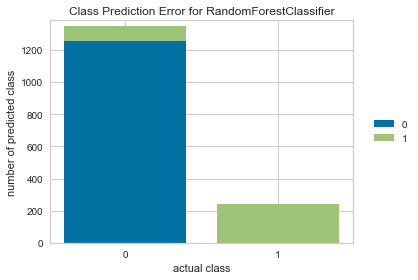

In [74]:
# Instantiate the classification model and visualizer
vis_rf1 = ClassPredictionError(
    rf1, classes=[0,1])


# Evaluate the model on the test data
vis_rf1.score(x_test1, y_test1)

# Draw visualization
g = vis_rf1.poof()

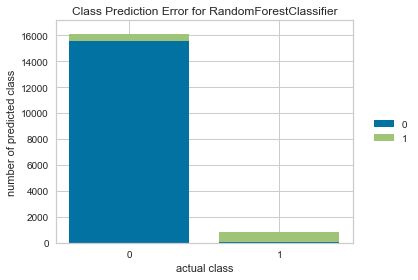

In [75]:
# Instantiate the classification model and visualizer
vis_rf1 = ClassPredictionError(
    rf1, classes=[0,1])


# Evaluate the model on the test data
vis_rf1.score(x_train1, y_train1)

# Draw visualization
g = vis_rf1.poof()

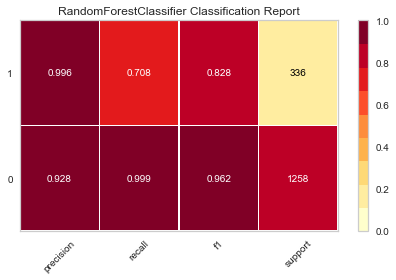

In [59]:
from yellowbrick.classifier import ClassificationReport

# Instantiate the classification model and visualizer
vis = ClassificationReport(rf1, classes=[0,1],support=True)

#vis.fit(x_test1, y_test1)  # Fit the visualizer and the model
vis.score(x_test1, y_test1)  # Evaluate the model on the test data
g = vis.poof()             # Draw/show/poof the data

<h2 style="color:#3295ec;text-align: right;">نتیجه‌گیری از بخش‌های 4-1 الی 4-5:</h2>
<p style="text-align: right;font-size:15px; margin-right: 10%;direction:rtl;">
همان‌طور که مشاهده می‌شود دقت تست و آموزش در مدل‌های فوق که بر روی داده‌ی نامتوازن آموزش دیده‌اند بالاست این در حالیست که معیار f1 طبق جداول گزارش رده‌بندی، درصد کمتری را گزارش می‌کند.
بنابراین دقت بالای مشاهده شده حاکی از یادگیری کلاس اکثریت توسط رده‌بند است و این مسئله موجب می‌شود تا برای به دست آوردن دقت و معیار بهتر آموزش را بر روی داده‌ی متوازن انجام دهیم.
</p>

<h2 style="color:#3295ec;text-align: right;">بخش 4-6: RandomForestClassifier</h2>
<p style="text-align: right;font-size:15px; margin-right: 10%;direction:rtl;">
استفاده از داده‌های متوازن برای آموزش
</p>

In [33]:
#randomForest
#noGp in crossVal
print('1')
random_forest_clf_7 = RandomForestClassifier(n_estimators=750, max_depth=5, class_weight='balanced').fit(x_,y_)
print('2')
acc_random_forest_7 = cross_val_score(random_forest_clf_7, x_, y_, cv=20, scoring='f1', n_jobs=1)
print('3')

print(acc_random_forest_7)
print(np.mean(acc_random_forest_7))

testpred_rf_7 =random_forest_clf_7.predict(x_test)

print(metrics.f1_score(y_test, testpred_rf_7))

1
2
3
[ 0.89516129  0.93215739  0.90802348  0.89242521  0.89180328  0.90515595
  0.92236842  0.92471686  0.88777429  0.85283474  0.90815006  0.93026316
  0.92885375  0.90273363  0.93324433  0.9468729   0.93032787  0.92440318
  0.94659546  0.93691275]
0.915038900672
0.844776119403


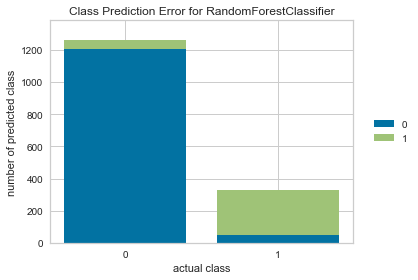

In [30]:
# Instantiate the classification model and visualizer
vis_rf7 = ClassPredictionError(
    rf7, classes=[0,1])


# Evaluate the model on the test data
vis_rf7.score(x_test, y_test)

# Draw visualization
g = vis_rf7.poof()

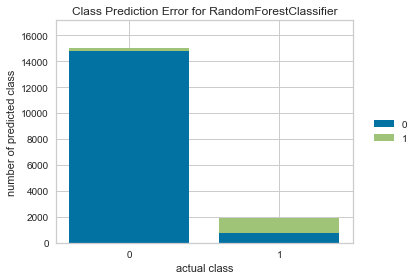

In [29]:
# Instantiate the classification model and visualizer
vis_rf7 = ClassPredictionError(
    rf7, classes=[0,1])


# Evaluate the model on the test data
vis_rf7.score(x_train, y_train)

# Draw visualization
g = vis_rf7.poof()

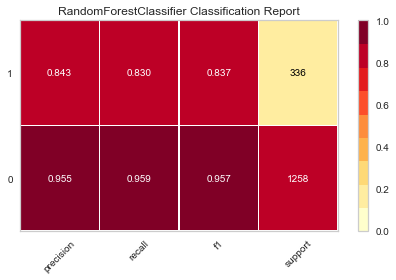

In [80]:
from yellowbrick.classifier import ClassificationReport

# Instantiate the classification model and visualizer
vis = ClassificationReport(rf7, classes=[0,1],support=True)

#vis.fit(x_test, y_test)  # Fit the visualizer and the model
vis.score(x_test, y_test)  # Evaluate the model on the test data
g = vis.poof()             # Draw/show/poof the data

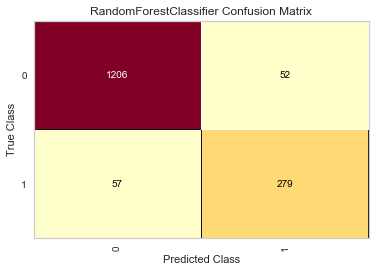

In [97]:
cm = ConfusionMatrix(rf7, classes=[0,1])

cm.score(x_test, y_test)

cm.poof()

1
2
3


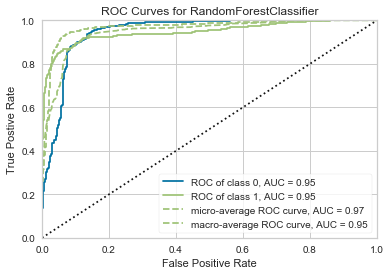

In [167]:
#randomForest
#noGp in crossVal
from yellowbrick.classifier import ROCAUC
from sklearn.ensemble import RandomForestClassifier

print('1')
random_forest_clf_7 = RandomForestClassifier(n_estimators=750, max_depth=5, class_weight='balanced')
print('2')
visualizer = ROCAUC(random_forest_clf_7)
visualizer.fit(x_,y_)

print('3')

visualizer.score(x_test, y_test)  # Evaluate the model on the test data
g = visualizer.poof() 

1
2
3


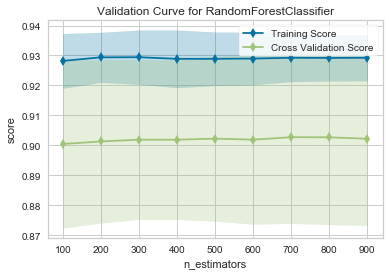

In [168]:
print("1")
vizrf_n_estimators = ValidationCurve(
    RandomForestClassifier(max_depth=5,class_weight="balanced"), param_name="n_estimators",
    param_range=np.arange(100,1000,100), cv=2, scoring="f1",n_jobs=8)
print("2")
# Fit and poof the visualizer
vizrf_n_estimators.fit(x_, y_)
print("3")
vizrf_n_estimators.poof()

1
2
3


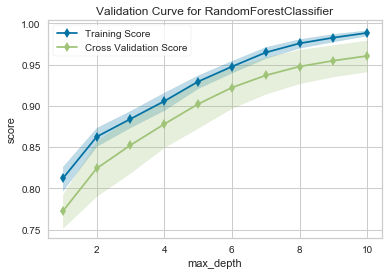

In [169]:
print("1")
vizrf_n_estimators = ValidationCurve(
    RandomForestClassifier(n_estimators=750,class_weight="balanced"), param_name="max_depth",
    param_range=np.arange(1,11), cv=2, scoring="f1",n_jobs=8)
print("2")
# Fit and poof the visualizer
vizrf_n_estimators.fit(x_, y_)
print("3")
vizrf_n_estimators.poof()

In [35]:
#saveModel7
joblib.dump(random_forest_clf_7, 'rf7.pkl') 

['rf7.pkl']

<h2 style="color:#3295ec;text-align: right;">بخش 4-7: AdaBoostClassifier</h2>
<p style="text-align: right;font-size:15px; margin-right: 10%;direction:rtl;">
بعد از آموزش مدل، زمان ارزیابی متقابل بسیار طولانی بوده به همین دلیل محاسبه ارزیابی متقابل را متوقف نموده و دقت تست و آموزش محاسبه شده بر اساس متریک‌های مدل به دست‌آمده است.
</p>

In [54]:
from sklearn.ensemble import AdaBoostClassifier

AdB_clf = AdaBoostClassifier(n_estimators=1000).fit(x_,y_)
#AdB_acc = cross_val_score(AdB_clf, train_set, train_label_set, cv=20, scoring='f1_weighted')


KeyboardInterrupt: 

In [53]:
print(train_test_predictor(AdB_clf,x_,y_,x_test,y_test)) #AdaBoost n_estimator 1000

(0.98402291534054753, 0.78996865203761746)


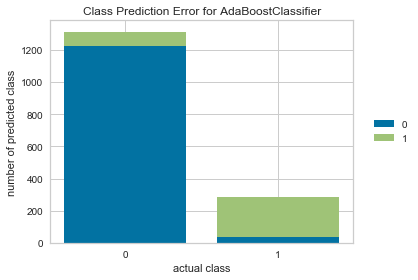

In [176]:
# Instantiate the classification model and visualizer
from yellowbrick.classifier import ClassPredictionError
vis = ClassPredictionError(
    adb, classes=[0,1])


# Evaluate the model on the test data
vis.score(x_test, y_test)

# Draw visualization
g = vis.poof()

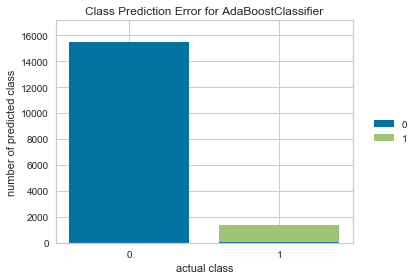

In [178]:
# Instantiate the classification model and visualizer
from yellowbrick.classifier import ClassPredictionError
vis = ClassPredictionError(
    adb, classes=[0,1])


# Evaluate the model on the test data
vis.score(x_train, y_train)

# Draw visualization
g = vis.poof()

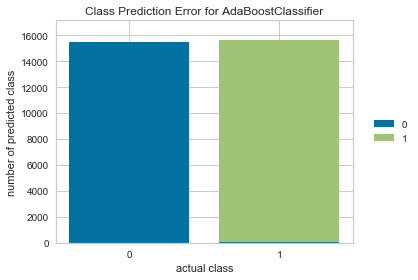

In [179]:
# Instantiate the classification model and visualizer
from yellowbrick.classifier import ClassPredictionError
vis = ClassPredictionError(
    adb, classes=[0,1])


# Evaluate the model on the test data
vis.score(x_, y_)

# Draw visualization
g = vis.poof()

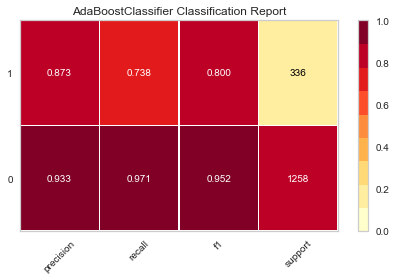

In [174]:

from yellowbrick.classifier import ClassificationReport

# Instantiate the classification model and visualizer
vis = ClassificationReport(adb, classes=[0,1],support=True)

vis.score(x_test, y_test)  # Evaluate the model on the test data
g = vis.poof()             # Draw/show/poof the data

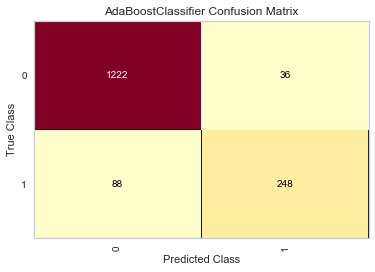

In [175]:
from yellowbrick.classifier import ConfusionMatrix

cm = ConfusionMatrix(adb, classes=[0,1])

cm.score(x_test,y_test)
cm.poof()

1
2
3


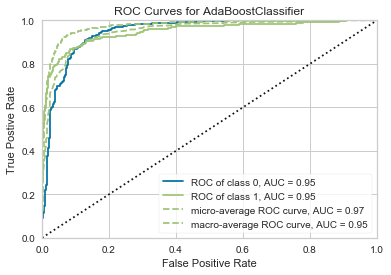

In [10]:
from sklearn.ensemble import AdaBoostClassifier

print("1")
AdB_clf = AdaBoostClassifier(n_estimators=1000)

print("2")
visualizer = ROCAUC(AdB_clf)
visualizer.fit(x_,y_)

print("3")
visualizer.score(x_test, y_test)  # Evaluate the model on the test data
g = visualizer.poof()             # Draw/show/poof the data


1
2
3


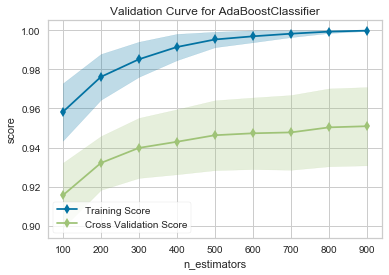

In [173]:
#AdaBoost Classifier (12)
from sklearn.ensemble import AdaBoostClassifier
print("1")
vizSGD_alpha = ValidationCurve(
    AdaBoostClassifier(), param_name="n_estimators",
    param_range=np.arange(100,1000,100), cv=2, scoring="f1",n_jobs=8)
print("2")
# Fit and poof the visualizer
vizSGD_alpha.fit(x_, y_)
print("3")
vizSGD_alpha.poof()


<h2 style="color:#3295ec;text-align: right;">بخش 4-8: MLPClassifier</h2>

In [44]:
#MLP
from sklearn.neural_network import MLPClassifier
print("1")
MLP2 = MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(25, 10), random_state=1).fit(x_,y_)
print("2")

acc3=cross_val_score(MLP2,x_, y_, cv=10, scoring='f1')

print("3")
print(acc3)
print(np.mean(acc3))

testpredMLP=MLP.predict(x_test)
print(metrics.f1_score(y_test, testpredMLP))


1
2
3
[ 0.96251202  0.95282146  0.95641422  0.98281349  0.88735632  0.97597977
  0.93086719  0.98621353  0.9893514   0.96853367]
0.95928630802
0.823880597015


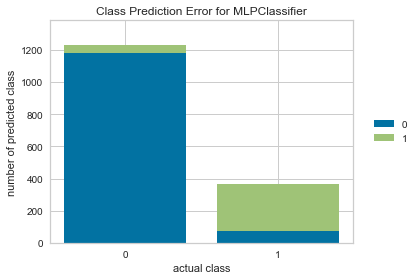

In [16]:
from yellowbrick.classifier import ClassPredictionError

# Instantiate the classification model and visualizer
vis_MLP82 = ClassPredictionError(
    MLP_82, classes=[0,1])


# Evaluate the model on the test data
vis_MLP82.score(x_test, y_test)

# Draw visualization
g = vis_MLP82.poof()

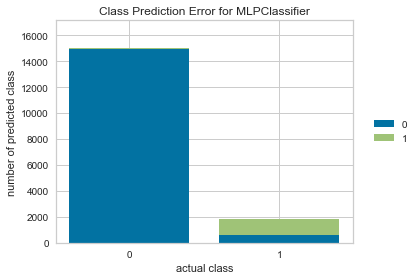

In [18]:
from yellowbrick.classifier import ClassPredictionError

# Instantiate the classification model and visualizer
vis_MLP82 = ClassPredictionError(
    MLP_82, classes=[0,1])


# Evaluate the model on the test data
vis_MLP82.score(x_train, y_train)

# Draw visualization
g = vis_MLP82.poof()

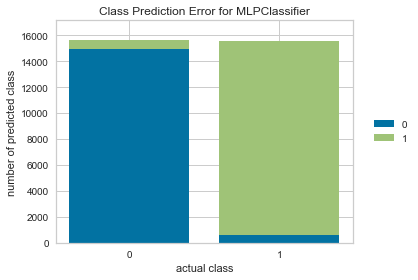

In [19]:
from yellowbrick.classifier import ClassPredictionError

# Instantiate the classification model and visualizer
vis_MLP82 = ClassPredictionError(
    MLP_82, classes=[0,1])


# Evaluate the model on the test data
vis_MLP82.score(x_, y_)

# Draw visualization
g = vis_MLP82.poof()

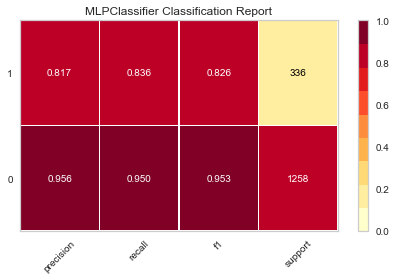

In [60]:
from yellowbrick.classifier import ClassificationReport

# Instantiate the classification model and visualizer
vis = ClassificationReport(MLP_82, classes=[0,1],support=True)

#vis.fit(x_test, y_test)  # Fit the visualizer and the model
vis.score(x_test, y_test)  # Evaluate the model on the test data
g = vis.poof()             # Draw/show/poof the data

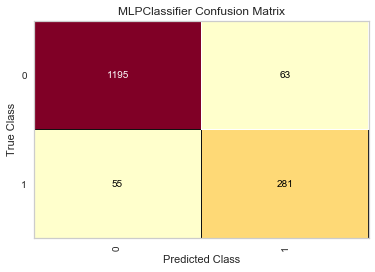

In [92]:
from yellowbrick.classifier import ConfusionMatrix

cm = ConfusionMatrix(MLP_82, classes=[0,1])

cm.score(x_test, y_test)

cm.poof()


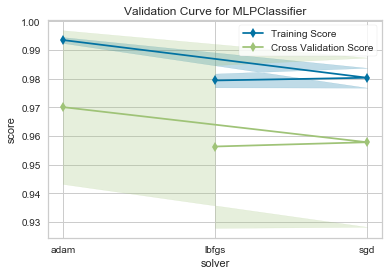

In [16]:
from sklearn.neural_network import MLPClassifier
vizMLP_solver = ValidationCurve(
    MLPClassifier(alpha=1e-5,hidden_layer_sizes=(25, 10), random_state=1), param_name="solver",
    param_range=['adam','sgd','lbfgs'], cv=10, scoring="f1")

# Fit and poof the visualizer
vizMLP_solver.fit(x_, y_)
vizMLP_solver.poof()

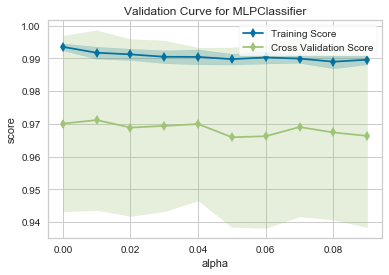

In [17]:
from sklearn.neural_network import MLPClassifier
vizMLP_solver = ValidationCurve(
    MLPClassifier(solver= "adam",hidden_layer_sizes=(25, 10), random_state=1), param_name="alpha",
    param_range=np.arange(1e-5,0.1,0.01), cv=10, scoring="f1")

# Fit and poof the visualizer
vizMLP_solver.fit(x_, y_)
vizMLP_solver.poof()

1
2
3


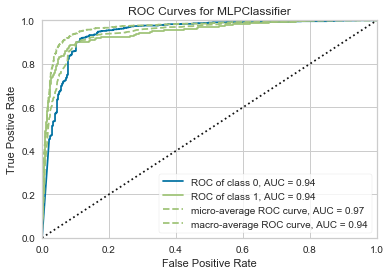

In [155]:
from yellowbrick.classifier import ROCAUC
from sklearn.neural_network import MLPClassifier
print("1")
MLP2 = MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(25, 10), random_state=1)
print("2")

visualizer = ROCAUC(MLP2)
visualizer.fit(x_,y_)
print("3")
visualizer.score(x_test, y_test)  # Evaluate the model on the test data
g = visualizer.poof()             # Draw/show/poof the data


<h2 style="color:#3295ec;text-align: right;">بخش 4-9: LogisticRegression</h2>

In [44]:
logReg_66=joblib.load('logReg-66.5-ncv.pkl')

c:\users\daeruser\appdata\local\programs\python\python35\lib\site-packages\sklearn\base.py:311: UserWarning: Trying to unpickle estimator LogisticRegression from version 0.19.0 when using version 0.19.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [28]:
#logReg (5)
from sklearn.linear_model import LogisticRegression

logReg= LogisticRegression().fit(x_,y_)

testpredlogreg=logReg.predict(x_test)
trainpredlogreg=logReg.predict(x_)

print(metrics.f1_score(y_,trainpredlogreg))

print(metrics.f1_score(y_test,testpredlogreg))

# logreg_acc=cross_val_score(logReg,train_normalized,train_labels,cv=10,scoring='accuracy')

# print(logreg_acc)
# print(np.mean(logreg_acc))

#results.append(logReg.predict(test_normalized))


0.941810686539
0.665868263473


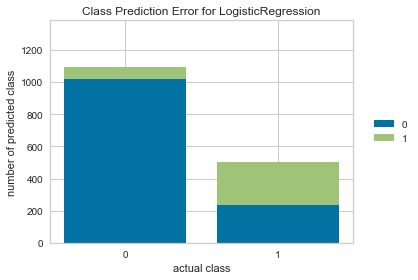

In [36]:
# Instantiate the classification model and visualizer
vis_logReg_66 = ClassPredictionError(
    logReg_66, classes=[0,1])


# Evaluate the model on the test data
vis_logReg_66.score(x_test, y_test)

# Draw visualization
g = vis_logReg_66.poof()

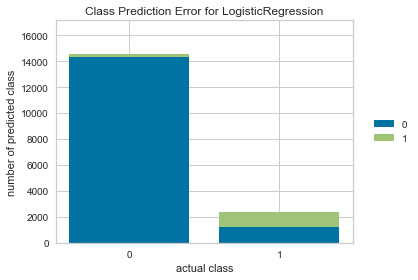

In [37]:
# Instantiate the classification model and visualizer
vis_logReg_66 = ClassPredictionError(
    logReg_66, classes=[0,1])


# Evaluate the model on the test data
vis_logReg_66.score(x_train, y_train)

# Draw visualization
g = vis_logReg_66.poof()

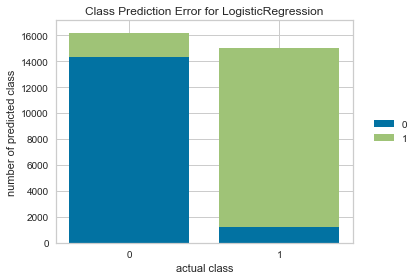

In [38]:
# Instantiate the classification model and visualizer
vis_logReg_66 = ClassPredictionError(
    logReg_66, classes=[0,1])


# Evaluate the model on the test data
vis_logReg_66.score(x_, y_)

# Draw visualization
g = vis_logReg_66.poof()

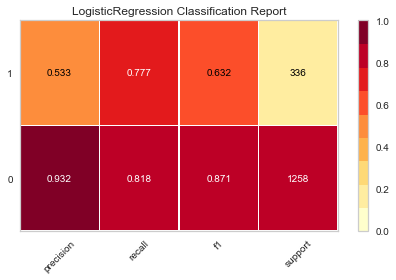

In [62]:
from yellowbrick.classifier import ClassificationReport

# Instantiate the classification model and visualizer
vis = ClassificationReport(logReg_66, classes=[0,1],support=True)

#vis.fit(x_test, y_test)  # Fit the visualizer and the model
vis.score(x_test, y_test)  # Evaluate the model on the test data
g = vis.poof()             # Draw/show/poof the data

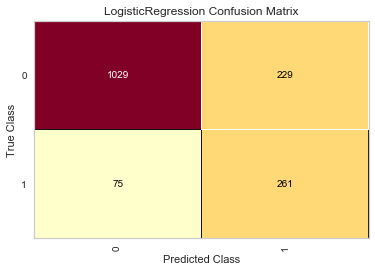

In [98]:
cm = ConfusionMatrix(logReg_66, classes=[0,1])

cm.score(x_test, y_test)

cm.poof()

<h2 style="color:#3295ec;text-align: right;">بخش 4-10: StochasticGradientDescent</h2>

In [45]:
sgd_79=joblib.load('sgd-79.6.pkl')

c:\users\daeruser\appdata\local\programs\python\python35\lib\site-packages\sklearn\base.py:311: UserWarning: Trying to unpickle estimator SGDClassifier from version 0.19.0 when using version 0.19.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


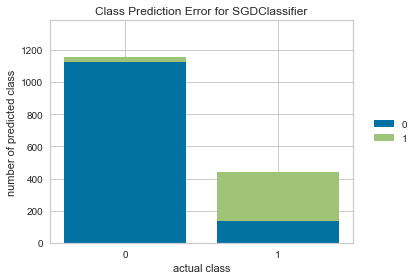

In [43]:
# Instantiate the classification model and visualizer
vis_sgd_79 = ClassPredictionError(
    sgd_79, classes=[0,1])


# Evaluate the model on the test data
vis_sgd_79.score(x_test, y_test)

# Draw visualization
g = vis_sgd_79.poof()

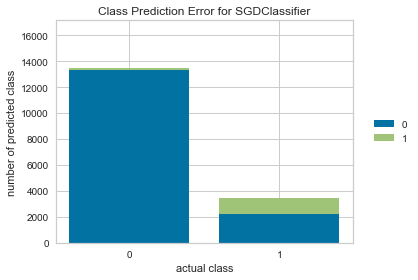

In [44]:
# Instantiate the classification model and visualizer
vis_sgd_79 = ClassPredictionError(
    sgd_79, classes=[0,1])


# Evaluate the model on the test data
vis_sgd_79.score(x_train, y_train)

# Draw visualization
g = vis_sgd_79.poof()

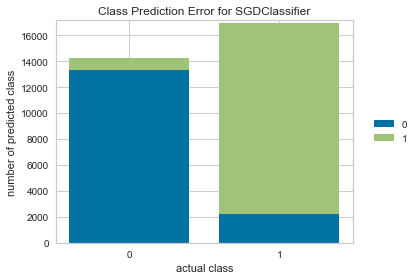

In [45]:
# Instantiate the classification model and visualizer
vis_sgd_79 = ClassPredictionError(
    sgd_79, classes=[0,1])


# Evaluate the model on the test data
vis_sgd_79.score(x_, y_)

# Draw visualization
g = vis_sgd_79.poof()

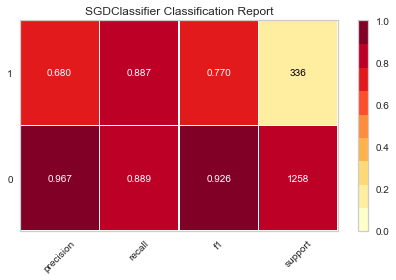

In [63]:
from yellowbrick.classifier import ClassificationReport

# Instantiate the classification model and visualizer
vis = ClassificationReport(sgd_79, classes=[0,1],support=True)

#vis.fit(x_test, y_test)  # Fit the visualizer and the model
vis.score(x_test, y_test)  # Evaluate the model on the test data
g = vis.poof()             # Draw/show/poof the data

/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/stochastic_gradient.py:84: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


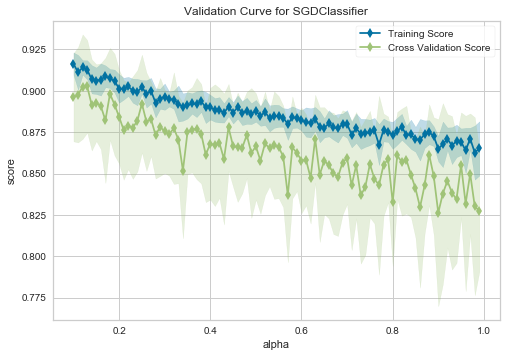

In [57]:
from sklearn.linear_model import SGDClassifier
vizSGD_alpha = ValidationCurve(
    SGDClassifier(class_weight= "balanced", loss='hinge', penalty='l2', power_t=0.5,
       shuffle=True), param_name="alpha",
    param_range=np.arange(0.1,1,0.01), cv=10, scoring="f1")

# Fit and poof the visualizer
vizSGD_alpha.fit(x_, y_)
vizSGD_alpha.poof()

/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/stochastic_gradient.py:84: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


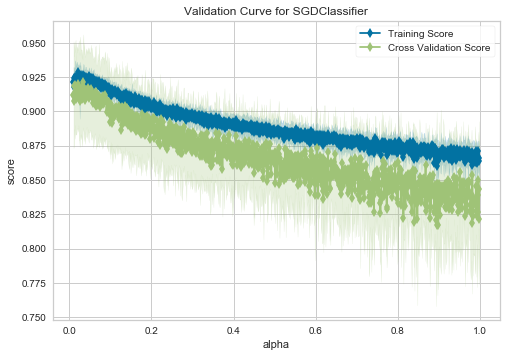

In [59]:
from sklearn.linear_model import SGDClassifier
vizSGD_alpha = ValidationCurve(
    SGDClassifier(class_weight= "balanced", loss='hinge', penalty='l2', power_t=0.5,
       shuffle=True), param_name="alpha",
    param_range=np.arange(0.01,1,0.001), cv=10, scoring="f1")

# Fit and poof the visualizer
vizSGD_alpha.fit(x_, y_)
vizSGD_alpha.poof()

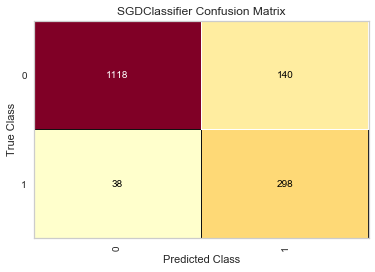

In [99]:
cm = ConfusionMatrix(sgd_79, classes=[0,1])

cm.score(x_test, y_test)

cm.poof()

<h2 style="color:#3295ec;text-align: right;">بخش 4-11: GradientBoosting</h2>

In [33]:
#GradientBoosting (7)
from sklearn.ensemble import GradientBoostingClassifier

GBC_clf2 = GradientBoostingClassifier(n_estimators=1000, learning_rate=0.1, max_depth=5).fit(x_, y_)
#GBC_acc=cross_val_score(GBC_clf,x_train,y_train,cv=10,scoring='f1_weighted')

testpredGBC2=GBC_clf2.predict(x_test)

print(metrics.f1_score(y_test, testpredGBC2))

trainpredGBC2=GBC_clf.predict(x_)

print(metrics.f1_score(y_,trainpredGBC2))

# print(GBC_acc)
# print(np.mean(GBC_acc))

0.840390879479
0.957336637123


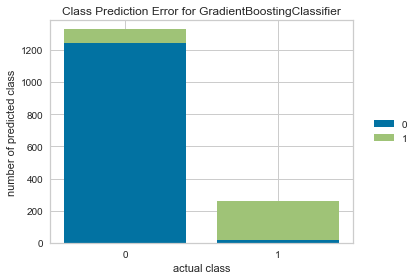

In [183]:
# Instantiate the classification model and visualizer
from yellowbrick.classifier import ClassPredictionError
vis = ClassPredictionError(
    gbc, classes=[0,1])


# Evaluate the model on the test data
vis.score(x_test, y_test)

# Draw visualization
g = vis.poof()

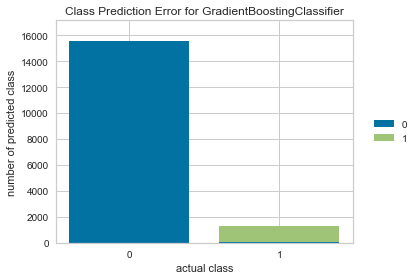

In [184]:
# Instantiate the classification model and visualizer
from yellowbrick.classifier import ClassPredictionError
vis = ClassPredictionError(
    gbc, classes=[0,1])


# Evaluate the model on the test data
vis.score(x_train, y_train)

# Draw visualization
g = vis.poof()

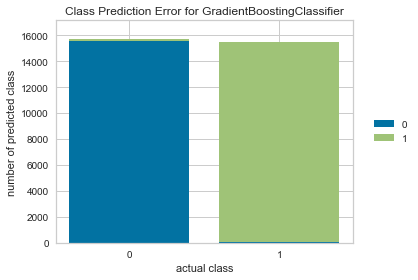

In [185]:
# Instantiate the classification model and visualizer
from yellowbrick.classifier import ClassPredictionError
vis = ClassPredictionError(
    gbc, classes=[0,1])


# Evaluate the model on the test data
vis.score(x_, y_)

# Draw visualization
g = vis.poof()

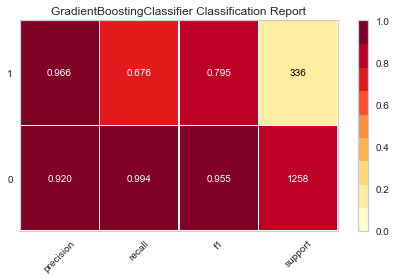

In [69]:
from yellowbrick.classifier import ClassificationReport

# Instantiate the classification model and visualizer
vis = ClassificationReport(gbc, classes=[0,1],support=True)

#vis.fit(x_test, y_test)  # Fit the visualizer and the model
vis.score(x_test1, y_test1)  # Evaluate the model on the test data
g = vis.poof()             # Draw/show/poof the data

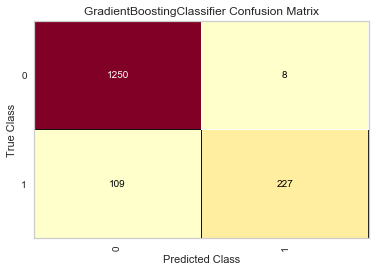

In [103]:
cm = ConfusionMatrix(gbc, classes=[0,1])

cm.score(x_test1, y_test1)

cm.poof()

1
2
3


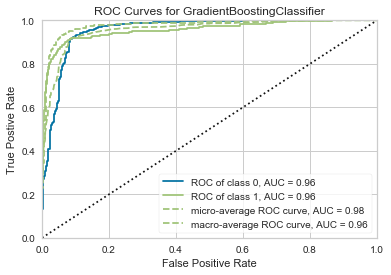

In [156]:
from yellowbrick.classifier import ROCAUC
from sklearn.ensemble import GradientBoostingClassifier
print("1")

GBC_clf2 = GradientBoostingClassifier(n_estimators=1000, learning_rate=0.1, max_depth=5)

print("2")
visualizer = ROCAUC(GBC_clf2)
visualizer.fit(x_,y_)

print("3")
visualizer.score(x_test, y_test)  # Evaluate the model on the test data
g = visualizer.poof()             # Draw/show/poof the data

<h2 style="color:#3295ec;text-align: right;">بخش 4-12: SVM</h2>

In [23]:
#svm
print("1")
lsvm=svm.SVC(kernel='linear',C=1).fit(x_,y_)
print("2")
accfold2s=cross_val_score(lsvm,x_, y_, cv=2, scoring='f1')
# Fit and poof the visualizer
print("3")
print(accfold2)
print(np.mean(accfold2))

testper2=lsvm.predict(x_test)
print(metrics.f1_score(y_test,testper2))

1
2
3
[ 0.91762351  0.96263763]
0.9401305702
0.753209700428


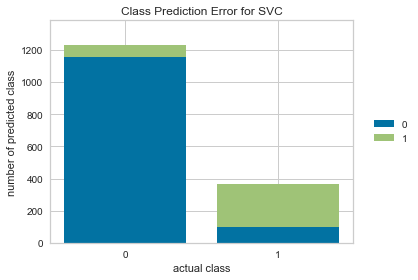

In [34]:
# Instantiate the classification model and visualizer
from yellowbrick.classifier import ClassPredictionError
vis = ClassPredictionError(
    lsvm, classes=[0,1])


# Evaluate the model on the test data
vis.score(x_test, y_test)

# Draw visualization
g = vis.poof()

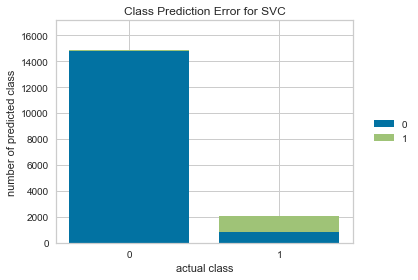

In [36]:
# Instantiate the classification model and visualizer
from yellowbrick.classifier import ClassPredictionError
vis = ClassPredictionError(
    lsvm, classes=[0,1])


# Evaluate the model on the test data
vis.score(x_train, y_train)

# Draw visualization
g = vis.poof()

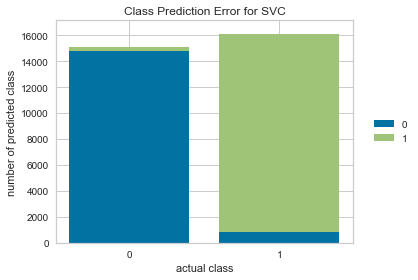

In [35]:
# Instantiate the classification model and visualizer
from yellowbrick.classifier import ClassPredictionError
vis = ClassPredictionError(
    lsvm, classes=[0,1])


# Evaluate the model on the test data
vis.score(x_, y_)

# Draw visualization
g = vis.poof()

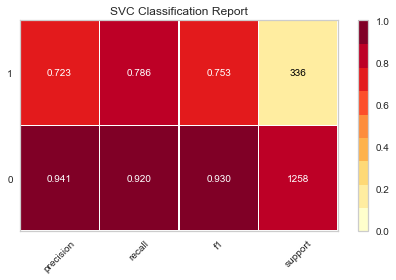

In [32]:
from yellowbrick.classifier import ClassificationReport

# Instantiate the classification model and visualizer
vis = ClassificationReport(lsvm, classes=[0,1],support=True)

vis.score(x_test, y_test)  # Evaluate the model on the test data
g = vis.poof()             # Draw/show/poof the data

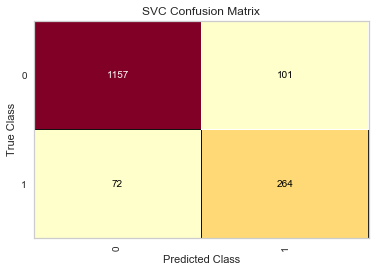

In [33]:
from yellowbrick.classifier import ConfusionMatrix

cm = ConfusionMatrix(lsvm, classes=[0,1])

cm.score(x_test,y_test)
cm.poof()

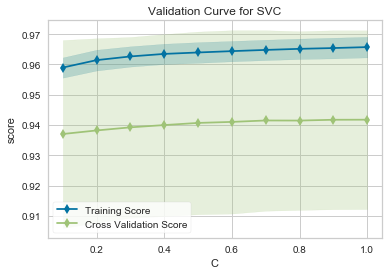

In [13]:
vizSvmL_max_depth = ValidationCurve(
    svm.SVC(kernel='linear'), param_name="C",
    param_range=np.arange(0.1,1.1,0.1), cv=10, scoring="f1")

# Fit and poof the visualizer
vizSvmL_max_depth.fit(x_, y_)
vizSvmL_max_depth.poof()

<h2 style="color:#3295ec;text-align: right;">بخش 4-13: KNN</h2>

In [15]:
#knn
print("1")
knn500 = KNeighborsClassifier(n_neighbors=5).fit(x_,y_)
print("2")
accfold2=cross_val_score(knn500,x_, y_, cv=2, scoring='f1')



1
2
3
[ 0.88388451  0.94200181]


NameError: name 'mean' is not defined

In [16]:
print("3")
print(accfold2)
print(np.mean(accfold2))

testper=knn500.predict(x_test)
print(metrics.f1_score(y_test,testper))

3
[ 0.88388451  0.94200181]
0.912943161407
0.754521963824


In [17]:
print("1")
knn500 = KNeighborsClassifier(n_neighbors=3).fit(x_,y_)
print("2")
accfold2=cross_val_score(knn500,x_, y_, cv=2, scoring='f1')

print("3")
print(accfold2)
print(np.mean(accfold2))

testper=knn500.predict(x_test)
print(metrics.f1_score(y_test,testper))

1
2
3
[ 0.89074286  0.94556709]
0.918154971262
0.777479892761


In [18]:
print("1")
knn500 = KNeighborsClassifier(n_neighbors=2).fit(x_,y_)
print("2")
accfold2=cross_val_score(knn500,x_, y_, cv=2, scoring='f1')

print("3")
print(accfold2)
print(np.mean(accfold2))

testper=knn500.predict(x_test)
print(metrics.f1_score(y_test,testper))

1
2
3
[ 0.91762351  0.96263763]
0.9401305702
0.788489208633


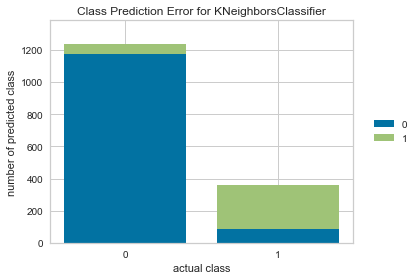

In [28]:
# Instantiate the classification model and visualizer
from yellowbrick.classifier import ClassPredictionError
vis = ClassPredictionError(
    knn500, classes=[0,1])


# Evaluate the model on the test data
vis.score(x_test, y_test)

# Draw visualization
g = vis.poof()

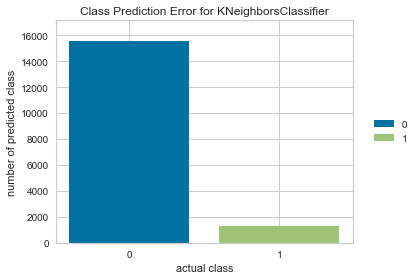

In [29]:
# Instantiate the classification model and visualizer
from yellowbrick.classifier import ClassPredictionError
vis = ClassPredictionError(
    knn500, classes=[0,1])


# Evaluate the model on the test data
vis.score(x_train, y_train)

# Draw visualization
g = vis.poof()

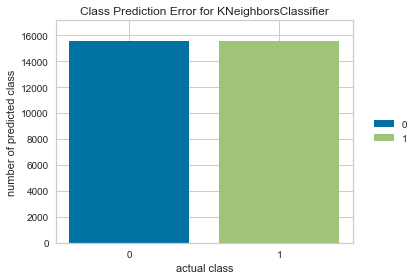

In [30]:
# Instantiate the classification model and visualizer
from yellowbrick.classifier import ClassPredictionError
vis = ClassPredictionError(
    knn500, classes=[0,1])


# Evaluate the model on the test data
vis.score(x_, y_)

# Draw visualization
g = vis.poof()

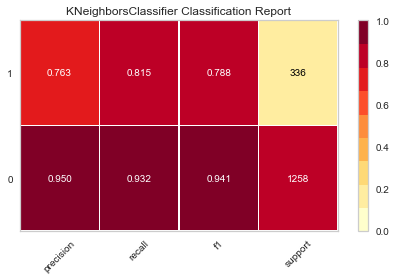

In [24]:
from yellowbrick.classifier import ClassificationReport

# Instantiate the classification model and visualizer
vis = ClassificationReport(knn500, classes=[0,1],support=True)

vis.score(x_test, y_test)  # Evaluate the model on the test data
g = vis.poof()             # Draw/show/poof the data

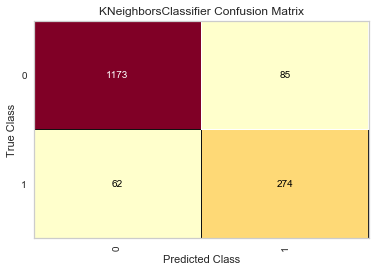

In [26]:
from yellowbrick.classifier import ConfusionMatrix

cm = ConfusionMatrix(knn500, classes=[0,1])

cm.score(x_test,y_test)
cm.poof()

1
2
3


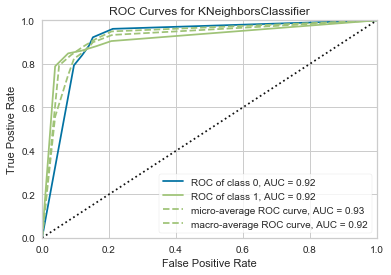

In [166]:

from yellowbrick.classifier import ROCAUC
from sklearn.neighbors import KNeighborsClassifier

print("1")

knnclf =  KNeighborsClassifier(n_neighbors= 5)

print("2")
visualizer = ROCAUC(knnclf)
visualizer.fit(x_,y_)

print("3")
visualizer.score(x_test, y_test)  # Evaluate the model on the test data
g = visualizer.poof()             # Draw/show/poof the data


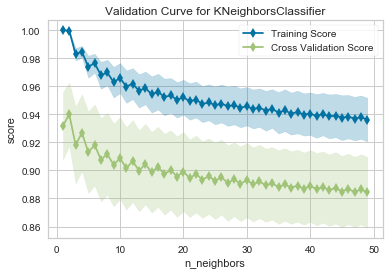

In [13]:
from sklearn.neighbors import KNeighborsClassifier
vizKNN_nigh = ValidationCurve(
    KNeighborsClassifier(), param_name="n_neighbors",
    param_range=np.arange(1,50), cv=2, scoring="f1",n_jobs=8)

# Fit and poof the visualizer
vizKNN_nigh.fit(x_, y_)
vizKNN_nigh.poof()

<p style="text-align: right;direction:rtl;"> دراین تابع با گرفتن classifier و داده train و test و برچسب‌ها آن‌ها، ابتدا به پیش‌بینی مقادیر برچسب‌ها پرداخته و سپس با مقایسه آن‌ها مقدار f1_score برای داده‌ی train و test محاسبه می‌شود.</p>

In [52]:
def train_test_predictor(clf,x_,y_,x_test,y_test):
    trainpred=clf.predict(x_)
    testpred=clf.predict(x_test)
    return metrics.f1_score(y_, trainpred),metrics.f1_score(y_test, testpred)


<h2 style="color:#3295ec;text-align: right;">بخش 5: مقایسه‌ی تاثیر تعداد فیچرها در معیار f1</h2>


<p style="text-align: right;font-size:15px; margin-right: 10%;direction:rtl;">
بررسی مدل‌ها با تعداد ویژگی‌های کم تا حداکثر 500 صورت گرفته‌است. برای تعداد ویژگی‌های بالاتر زمان آموزش مدل طولانی بوده و در مواردی به خطای حافظه برخورد کرده‌است.
</p>

In [ ]:
from sklearn.model_selection import LeavePGroupsOut
from sklearn.model_selection import GroupKFold
from imblearn.over_sampling import SMOTE

def initializing(train_data, labels):
  kgf = LeavePGroupsOut(4)
  for i, j in kgf.split(train_data, groups=imgIndices):
    x_train, x_test = train_data[i], train_data[j]
    y_train, y_test = labels[i], labels[j]
    train_group, test_group = images_groups[i], images_groups[j]
    break
#   print(x_train.shape, ' , ', y_train.shape, ' , ', train_group.shape)
#   print(x_test.shape, ' , ', y_test.shape, ' , ', test_group.shape)
  if len(np.unique(train_group)) > 1:
    cv_ = GroupKFold().get_n_splits(X= x_train, y= y_train, groups=train_group)
  else:
    cv_ = KFold(9, shuffle=True, random_state=45)
#   print(len(x_train),len(y_train),len(train_group))
  sm = SMOTE(random_state=45)
  x_, y_ = sm.fit_sample(x_train, y_train)
#   print(len(x_),len(y_),len(train_group))
  
  return x_, y_, x_test, y_test

<h2 style="color:#3295ec;text-align: right;">بخش 5-1: RandomForestClassifier max_depth:5</h2>


In [22]:
from sklearn.ensemble import RandomForestClassifier
index = 0
f1_random_forest_e750_d5_cv2_train  = []
f1_random_forest_e750_d5_cv2_test  = []
while index < 5:
  x_, y_, x_test, y_test = initializing(train_with_pca[index], train_labels)
  print('start fitting:')
  random_forest_clf = RandomForestClassifier(n_estimators=750, max_depth=5).fit(x_,y_)
  print('done with fitting, start cross validation')
  acc_random_forest = cross_val_score(random_forest_clf, x_, y_, cv=2, scoring='f1', n_jobs=1)
  print('done with cross validation')
  print("Result in data with ", number_of_feature[index], " features: " )
  print("f1 train: ")
  print(acc_random_forest)
  print(np.mean(acc_random_forest))
  f1_random_forest_e750_d5_cv2_train.append(np.mean(acc_random_forest))
  p = random_forest_clf.predict(x_test)
  test_result = metrics.f1_score(y_test, p)
  f1_random_forest_e750_d5_cv2_test.append(test_result)
  print("f1 test: ")
  print(test_result)
  print("***********************************************************")
  index += 1


(16922, 10)  ,  (16922,)  ,  (16922,)
(1594, 10)  ,  (1594,)  ,  (1594,)
16922 16922 16922
31188 31188 16922
start fitting:
done with fitting, start cross validation
done with cross validation
Result in data with  10  features: 
f1 train: 
[0.84474469 0.8829794 ]
0.8638620458696336
f1 test: 
0.7313432835820897
***********************************************************
(16922, 20)  ,  (16922,)  ,  (16922,)
(1594, 20)  ,  (1594,)  ,  (1594,)
16922 16922 16922
31188 31188 16922
start fitting:
done with fitting, start cross validation
done with cross validation
Result in data with  20  features: 
f1 train: 
[0.8460039  0.88402848]
0.8650161914337104
f1 test: 
0.7822580645161291
***********************************************************
(16922, 30)  ,  (16922,)  ,  (16922,)
(1594, 30)  ,  (1594,)  ,  (1594,)
16922 16922 16922
31188 31188 16922
start fitting:
done with fitting, start cross validation
done with cross validation
Result in data with  30  features: 
f1 train: 
[0.84037214 0.87

In [29]:
index = 5
while index < 10:
  x_, y_, x_test, y_test = initializing(train_with_pca[index], train_labels)
  print('start fitting:')
  random_forest_clf = RandomForestClassifier(n_estimators=750, max_depth=5).fit(x_,y_)
  print('done with fitting, start cross validation')
  acc_random_forest = cross_val_score(random_forest_clf, x_, y_, cv=2, scoring='f1', n_jobs=1)
  print('done with cross validation')
  print("Result in data with ", number_of_feature[index], " features: " )
  print("f1 train: ")
  print(acc_random_forest)
  print(np.mean(acc_random_forest))
  f1_random_forest_e750_d5_cv2_train.append(np.mean(acc_random_forest))
  p = random_forest_clf.predict(x_test)
  test_result = metrics.f1_score(y_test, p)
  f1_random_forest_e750_d5_cv2_test.append(test_result)
  print("f1 test: ")
  print(test_result)
  print("***********************************************************")
  index += 1
  


(16922, 100)  ,  (16922,)  ,  (16922,)
(1594, 100)  ,  (1594,)  ,  (1594,)
16922 16922 16922
31188 31188 16922
start fitting:
done with fitting, start cross validation
done with cross validation
Result in data with  100  features: 
f1 train: 
[0.84732541 0.88552545]
0.8664254273758187
f1 test: 
0.8139534883720929
***********************************************************
(16922, 200)  ,  (16922,)  ,  (16922,)
(1594, 200)  ,  (1594,)  ,  (1594,)
16922 16922 16922
31188 31188 16922
start fitting:
done with fitting, start cross validation
done with cross validation
Result in data with  200  features: 
f1 train: 
[0.84576806 0.89525692]
0.8705124904465098
f1 test: 
0.8266666666666667
***********************************************************
(16922, 300)  ,  (16922,)  ,  (16922,)
(1594, 300)  ,  (1594,)  ,  (1594,)
16922 16922 16922
31188 31188 16922
start fitting:
done with fitting, start cross validation
done with cross validation
Result in data with  300  features: 
f1 train: 
[0.8643

In [ ]:
import matplotlib.pyplot as plt

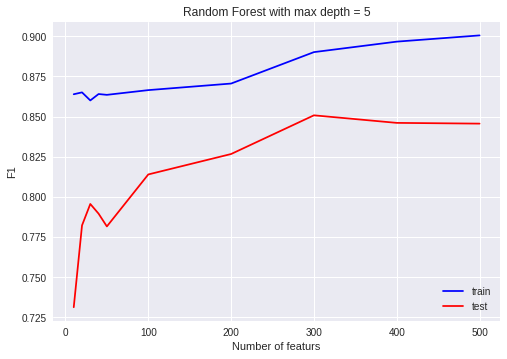

In [49]:
plt.xlabel("Number of featurs")
plt.ylabel("F1")
plt.title("Random Forest with max depth = 5")
plt.plot(number_of_feature, f1_random_forest_e750_d5_cv2_train, 'b', label="train")
plt.plot(number_of_feature, f1_random_forest_e750_d5_cv2_test, 'r', label='test')
plt.legend(loc='lower right')
plt.show()

<h2 style="color:#3295ec;text-align: right;">بخش 5-2: RandomForestClassifier max_depth:10</h2>


In [37]:
index = 0
f1_random_forest_e750_d10_cv2_train  = []
f1_random_forest_e750_d10_cv2_test  = []
while index < 10:
  x_, y_, x_test, y_test = initializing(train_with_pca[index], train_labels)
  print('start fitting:')
  random_forest_clf = RandomForestClassifier(n_estimators=750, max_depth=10).fit(x_,y_)
  print('done with fitting, start cross validation')
  acc_random_forest = cross_val_score(random_forest_clf, x_, y_, cv=2, scoring='f1', n_jobs=5)
  print('done with cross validation')
  print("Result in data with ", number_of_feature[index], " features: " )
  print("f1 train: ")
  print(acc_random_forest)
  print(np.mean(acc_random_forest))
  f1_random_forest_e750_d10_cv2_train.append(np.mean(acc_random_forest))
  p = random_forest_clf.predict(x_test)
  test_result = metrics.f1_score(y_test, p)
  f1_random_forest_e750_d10_cv2_test.append(test_result)
  print("f1 test: ")
  print(test_result)
  print("***********************************************************")
  index += 1


start fitting:
done with fitting, start cross validation
done with cross validation
Result in data with  10  features: 
f1 train: 
[0.90528949 0.94080259]
0.9230460423589846
f1 test: 
0.7729729729729731
***********************************************************
start fitting:
done with fitting, start cross validation
done with cross validation
Result in data with  20  features: 
f1 train: 
[0.90914507 0.94680587]
0.9279754681359662
f1 test: 
0.7926657263751763
***********************************************************
start fitting:
done with fitting, start cross validation
done with cross validation
Result in data with  30  features: 
f1 train: 
[0.9113547  0.94752531]
0.9294400030945789
f1 test: 
0.7999999999999999
***********************************************************
start fitting:
done with fitting, start cross validation
done with cross validation
Result in data with  40  features: 
f1 train: 
[0.92219817 0.95391906]
0.9380586171834535
f1 test: 
0.8231707317073171
********

Process ForkPoolWorker-36:


OSError: ignored

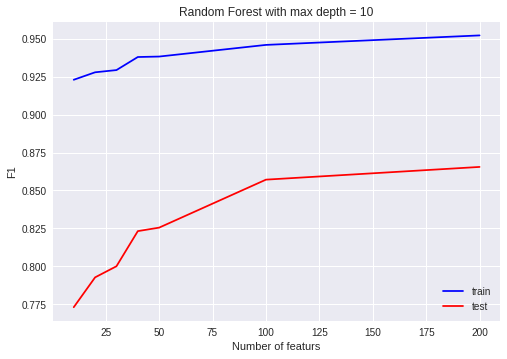

In [40]:
plt.xlabel("Number of featurs")
plt.ylabel("F1")
plt.title("Random Forest with max depth = 10")
plt.plot(number_of_feature[:7], f1_random_forest_e750_d10_cv2_train, 'b', label="train")
plt.plot(number_of_feature[:7], f1_random_forest_e750_d10_cv2_test, 'r', label='test')
plt.legend(loc='lower right')
plt.show()

<h2 style="color:#3295ec;text-align: right;">بخش 5-3: MLPClassifier</h2>


In [43]:
from sklearn.neural_network import MLPClassifier
index = 0
f1_mlp_clf_train  = []
f1_mlp_clf_test  = []
while index < 10:
  x_, y_, x_test, y_test = initializing(train_with_pca[index], train_labels)
  print('start fitting:')
  mlp_clf = MLPClassifier(solver= "adam",hidden_layer_sizes=(25, 10), random_state=1,alpha=1e-5).fit(x_,y_)
  print('done with fitting, start cross validation')
  acc_mlp = cross_val_score(mlp_clf, x_, y_, cv=2, scoring='f1', n_jobs=5)
  print('done with cross validation')
  print("Result in data with ", number_of_feature[index], " features: " )
  print("f1 train: ")
  print(acc_mlp)
  print(np.mean(acc_mlp))
  f1_mlp_clf_train.append(np.mean(acc_mlp))
  p = mlp_clf.predict(x_test)
  test_result = metrics.f1_score(y_test, p)
  f1_mlp_clf_test.append(test_result)
  print("f1 test: ")
  print(test_result)
  print("***********************************************************")
  index += 1



start fitting:
done with fitting, start cross validation
done with cross validation
Result in data with  10  features: 
f1 train: 
[0.86314568 0.88928313]
0.8762144045361022
f1 test: 
0.7840440165061898
***********************************************************
start fitting:
done with fitting, start cross validation
done with cross validation
Result in data with  20  features: 
f1 train: 
[0.90097596 0.91605772]
0.9085168399675589
f1 test: 
0.797583081570997
***********************************************************
start fitting:
done with fitting, start cross validation
done with cross validation
Result in data with  30  features: 
f1 train: 
[0.91489881 0.92701763]
0.9209582196783126
f1 test: 
0.7999999999999999
***********************************************************
start fitting:
done with fitting, start cross validation
done with cross validation
Result in data with  40  features: 
f1 train: 
[0.90780397 0.93818495]
0.9229944617797969
f1 test: 
0.8080808080808081
*********

Process ForkPoolWorker-81:


OSError: ignored

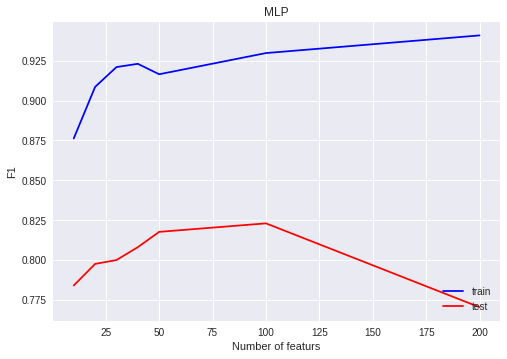

In [48]:
plt.xlabel("Number of featurs")
plt.ylabel("F1")
plt.title("MLP")
plt.plot(number_of_feature[:7], f1_mlp_clf_train, 'b', label="train")
plt.plot(number_of_feature[:7], f1_mlp_clf_test, 'r', label='test')
plt.legend(loc='lower right')
plt.show()

<h2 style="color:#3295ec;text-align: right;">بخش 5-4: StochasticGradientDescentClassifier<h2>


In [46]:
from sklearn.linear_model import SGDClassifier
index = 0
f1_sgd_clf_train  = []
f1_sgd_clf_test  = []
while index < 10:
  x_, y_, x_test, y_test = initializing(train_with_pca[index], train_labels)
  print('start fitting:')
  sgd_clf = SGDClassifier(loss="hinge", penalty="l2").fit(x_,y_)
  print('done with fitting, start cross validation')
  acc_sgd = cross_val_score(sgd_clf, x_, y_, cv=2, scoring='f1', n_jobs=5)
  print('done with cross validation')
  print("Result in data with ", number_of_feature[index], " features: " )
  print("f1 train: ")
  print(acc_sgd)
  print(np.mean(acc_sgd))
  f1_sgd_clf_train.append(np.mean(acc_sgd))
  p = sgd_clf.predict(x_test)
  test_result = metrics.f1_score(y_test, p)
  f1_sgd_clf_test.append(test_result)
  print("f1 test: ")
  print(test_result)
  print("***********************************************************")
  index += 1


start fitting:
done with fitting, start cross validation


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


done with cross validation
Result in data with  10  features: 
f1 train: 
[0.77023194 0.57083368]
0.670532808806632
f1 test: 
0.6787330316742082
***********************************************************
start fitting:
done with fitting, start cross validation


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


done with cross validation
Result in data with  20  features: 
f1 train: 
[0.76992587 0.64676283]
0.7083443524484341
f1 test: 
0.601980198019802
***********************************************************
start fitting:
done with fitting, start cross validation


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


done with cross validation
Result in data with  30  features: 
f1 train: 
[0.75556502 0.83710198]
0.7963335036046217
f1 test: 
0.6268041237113402
***********************************************************
start fitting:
done with fitting, start cross validation


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


done with cross validation
Result in data with  40  features: 
f1 train: 
[0.77519779 0.83720379]
0.8062007894118339
f1 test: 
0.6339869281045751
***********************************************************
start fitting:
done with fitting, start cross validation


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


done with cross validation
Result in data with  50  features: 
f1 train: 
[0.78775332 0.83406807]
0.8109106943804922
f1 test: 
0.6754176610978521
***********************************************************
start fitting:
done with fitting, start cross validation


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


done with cross validation
Result in data with  100  features: 
f1 train: 
[0.83451591 0.89333583]
0.8639258672368924
f1 test: 
0.7919463087248321
***********************************************************
start fitting:
done with fitting, start cross validation


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


done with cross validation
Result in data with  200  features: 
f1 train: 
[0.75122897 0.80401709]
0.7776230283311165
f1 test: 
0.8
***********************************************************
start fitting:


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


done with fitting, start cross validation


Process ForkPoolWorker-126:


OSError: ignored

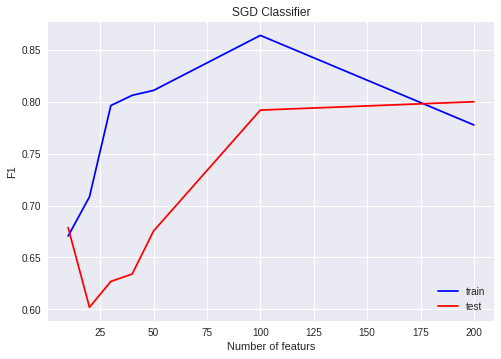

In [47]:
plt.xlabel("Number of featurs")
plt.ylabel("F1")
plt.title("SGD Classifier")
plt.plot(number_of_feature[:7], f1_sgd_clf_train, 'b', label="train")
plt.plot(number_of_feature[:7], f1_sgd_clf_test, 'r', label='test')
plt.legend(loc='lower right')
plt.show()

<h2 style="color:#3295ec;text-align: right;">بخش 5-5: GradientBoostingClassifier</h2>


In [50]:
from sklearn.ensemble import GradientBoostingClassifier
index = 0
f1_gb_clf_train  = []
f1_gb_clf_test  = []
while index < 10:
  x_, y_, x_test, y_test = initializing(train_with_pca[index], train_labels)
  print('start fitting:')
  gb_clf = GradientBoostingClassifier(n_estimators=1000, learning_rate=0.1, max_depth=1).fit(x_,y_)
  print('done with fitting, start cross validation')
  acc_gb = cross_val_score(gb_clf, x_, y_, cv=2, scoring='f1', n_jobs=5)
  print('done with cross validation')
  print("Result in data with ", number_of_feature[index], " features: " )
  print("f1 train: ")
  print(acc_gb)
  print(np.mean(acc_gb))
  f1_gb_clf_train.append(np.mean(acc_gb))
  p = gb_clf.predict(x_test)
  test_result = metrics.f1_score(y_test, p)
  f1_gb_clf_test.append(test_result)
  print("f1 test: ")
  print(test_result)
  print("***********************************************************")
  index += 1


start fitting:
done with fitting, start cross validation
done with cross validation
Result in data with  10  features: 
f1 train: 
[0.85705637 0.88      ]
0.8685281830840952
f1 test: 
0.7252475247524752
***********************************************************
start fitting:
done with fitting, start cross validation
done with cross validation
Result in data with  20  features: 
f1 train: 
[0.86402899 0.89567753]
0.8798532599651026
f1 test: 
0.7196029776674938
***********************************************************
start fitting:
done with fitting, start cross validation
done with cross validation
Result in data with  30  features: 
f1 train: 
[0.86352715 0.89873018]
0.8811286645971151
f1 test: 
0.7503267973856208
***********************************************************
start fitting:
done with fitting, start cross validation
done with cross validation
Result in data with  40  features: 
f1 train: 
[0.87274051 0.90325853]
0.88799951689321
f1 test: 
0.7837078651685393
**********

Process ForkPoolWorker-166:


OSError: ignored

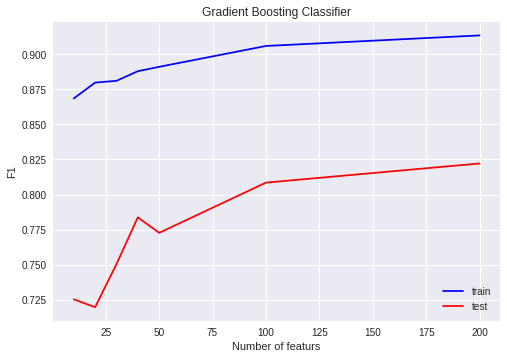

In [51]:
plt.xlabel("Number of featurs")
plt.ylabel("F1")
plt.title("Gradient Boosting Classifier")
plt.plot(number_of_feature[:7], f1_gb_clf_train, 'b', label="train")
plt.plot(number_of_feature[:7], f1_gb_clf_test, 'r', label='test')
plt.legend(loc='lower right')
plt.show()

<h2 style="color:#3295ec;text-align: right;">بخش 5-6: KNN 2-nn</h2>


In [21]:
index = 0
f1_knn_clf_n2_train  = []
f1_knn_clf_n2_test  = []
from sklearn.neighbors import KNeighborsClassifier
while index < 10:
  x_, y_, x_test, y_test = initializing(train_with_pca[index], train_labels)
  print('start fitting:')
  knn_clf = KNeighborsClassifier(n_neighbors=2).fit(x_,y_)
  print('done with fitting, start cross validation')
  acc_knn = cross_val_score(knn_clf, x_, y_, cv=2, scoring='f1', n_jobs=5)
  print('done with cross validation')
  print("Result in data with ", number_of_feature[index], " features: " )
  print("f1 train: ")
  print(acc_knn)
  print(np.mean(acc_knn))
  f1_knn_clf_n2_train.append(np.mean(acc_knn))
  p = knn_clf.predict(x_test)
  test_result = metrics.f1_score(y_test, p)
  f1_knn_clf_n2_test.append(test_result)
  print("f1 test: ")
  print(test_result)
  print("***********************************************************")
  index += 1


start fitting:
done with fitting, start cross validation
done with cross validation
Result in data with  10  features: 
f1 train: 
[0.92529458 0.95923947]
0.9422670215795794
f1 test: 
0.7181008902077152
***********************************************************
start fitting:
done with fitting, start cross validation
done with cross validation
Result in data with  20  features: 
f1 train: 
[0.92002848 0.96099225]
0.9405103622844486
f1 test: 
0.7350689127105666
***********************************************************
start fitting:
done with fitting, start cross validation
done with cross validation
Result in data with  30  features: 
f1 train: 
[0.92060861 0.96034152]
0.9404750644458973
f1 test: 
0.7405159332321699
***********************************************************
start fitting:
done with fitting, start cross validation
done with cross validation
Result in data with  40  features: 
f1 train: 
[0.91497499 0.95966397]
0.937319481003404
f1 test: 
0.7541984732824429
*********

OSError: ignored

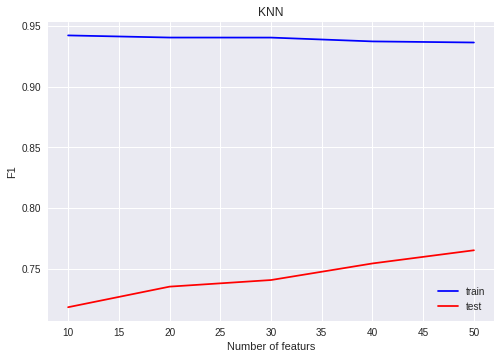

In [39]:
plt.xlabel("Number of featurs")
plt.ylabel("F1")
plt.title("KNN")
plt.plot(number_of_feature[:5], f1_knn_clf_n2_train[:5], 'b', label="train")
plt.plot(number_of_feature[:5], f1_knn_clf_n2_test[:5], 'r', label='test')
plt.legend(loc='lower right')
plt.show()

<h2 style="color:#3295ec;text-align: right;">بخش 5-7: AdaBoostClassifier</h2>


In [52]:
from sklearn.ensemble import AdaBoostClassifier
index = 0
f1_adb_clf_train  = []
f1_adb_clf_test  = []
while index < 10:
  x_, y_, x_test, y_test = initializing(train_with_pca[index], train_labels)
  print('start fitting:')
  adb_clf = AdaBoostClassifier(n_estimators=1000).fit(x_,y_)
  print('done with fitting, start cross validation')
  acc_adb = cross_val_score(adb_clf, x_, y_, cv=2, scoring='f1', n_jobs=5)
  print('done with cross validation')
  print("Result in data with ", number_of_feature[index], " features: " )
  print("f1 train: ")
  print(acc_adb)
  print(np.mean(acc_adb))
  f1_adb_clf_train.append(np.mean(acc_adb))
  p = adb_clf.predict(x_test)
  test_result = metrics.f1_score(y_test, p)
  f1_adb_clf_test.append(test_result)
  print("f1 test: ")
  print(test_result)
  print("***********************************************************")
  index += 1


start fitting:
done with fitting, start cross validation
done with cross validation
Result in data with  10  features: 
f1 train: 
[0.87426089 0.88329778]
0.8787793347223387
f1 test: 
0.7584345479082322
***********************************************************
start fitting:
done with fitting, start cross validation
done with cross validation
Result in data with  20  features: 
f1 train: 
[0.88942366 0.91054373]
0.8999836923589466
f1 test: 
0.7690179806362378
***********************************************************
start fitting:
done with fitting, start cross validation
done with cross validation
Result in data with  30  features: 
f1 train: 
[0.89732466 0.91832175]
0.907823202154693
f1 test: 
0.7884057971014493
***********************************************************
start fitting:
done with fitting, start cross validation
done with cross validation
Result in data with  40  features: 
f1 train: 
[0.90892532 0.9277913 ]
0.9183583093838127
f1 test: 
0.7674074074074074
*********

KeyboardInterrupt: ignored

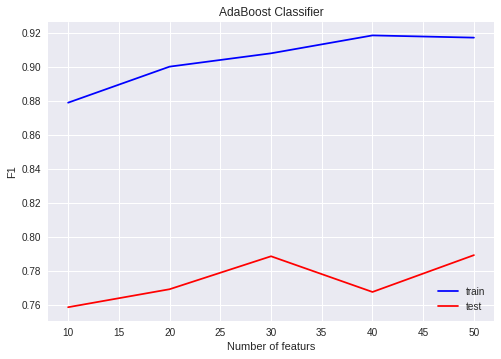

In [53]:
plt.xlabel("Number of featurs")
plt.ylabel("F1")
plt.title("AdaBoost Classifier")
plt.plot(number_of_feature[:5], f1_adb_clf_train, 'b', label="train")
plt.plot(number_of_feature[:5], f1_adb_clf_test, 'r', label='test')
plt.legend(loc='lower right')
plt.show()

<h2 style="color:#3295ec;text-align: right;">بخش 6: مدل نهایی</h2>
<p style="text-align: right;font-size:15px; margin-right: 10%;direction:rtl;">
با توجه به رده‌بندهای بررسی شده در بخش 4 و مقایسه‌ی عملکردی آن‌ها در بخش 5، رده‌بندهای زیر جهت مجمع رای‌گیری انتخاب شد:
</p>
<li>
MLP
<l/li>
<li>
KNN
<l/li>
<li>
Random Forest
<l/li>
<li>
Gradient Boosting
<l/li>
<li>
Ada Boost
<l/li>

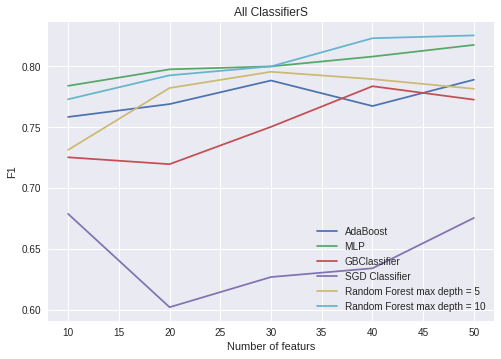

In [57]:
plt.xlabel("Number of featurs")
plt.ylabel("F1")
plt.title("All ClassifierS")
plt.plot(number_of_feature[:5], f1_adb_clf_test[:5], label="AdaBoost")
plt.plot(number_of_feature[:5], f1_mlp_clf_test[:5], label='MLP')
plt.plot(number_of_feature[:5], f1_gb_clf_test[:5], label='GBClassifier')
plt.plot(number_of_feature[:5], f1_sgd_clf_test[:5], label='SGD Classifier')
plt.plot(number_of_feature[:5], f1_random_forest_e750_d5_cv2_test[:5], label='Random Forest max depth = 5')
plt.plot(number_of_feature[:5], f1_random_forest_e750_d10_cv2_test[:5], label='Random Forest max depth = 10')
plt.legend(loc='lower right')
plt.show()

<h2 style="color:#3295ec;text-align: right;">بخش 6-1:</h2>


In [49]:
#voting 


MLP = MLPClassifier(solver= "adam",hidden_layer_sizes=(25, 10), random_state=1,alpha=1e-5)

knn = KNeighborsClassifier(n_neighbors=2)

random_forest_clf = RandomForestClassifier(n_estimators=750, max_depth=10, class_weight='balanced')

GBC_clf = GradientBoostingClassifier(n_estimators=1000, learning_rate=0.1, max_depth=1)

AdB_clf = AdaBoostClassifier(n_estimators=1000)

#sgd_clf = SGDClassifier(loss="hinge", penalty="l2")






ens_clf=VotingClassifier(estimators=[('kn', knn), ('ml', MLP),('gbc', GBC_clf), ('rf', random_forest_clf), 
                                     ('adb', AdB_clf)],
                                      voting='soft', weights=[2, 2, 3, 4, 2],n_jobs=10)




In [50]:
print("1")
ens_clf.fit(x_,y_)
print("2")


1
2


NameError: name 'acccv_ens' is not defined

In [51]:
testpredEns =ens_clf.predict(x_test)
print(metrics.f1_score(y_test,testpredEns))

print("ENSDone")

0.861491628615
ENSDone


In [53]:
joblib.dump(ens_clf,"ens_clf.pkl")

['ens_clf.pkl']

In [54]:
FinTestpred = ens_clf.predict(test_stdwPCA)

In [55]:
np.savetxt("EnsResults.txt", FinTestpred, fmt='%1d', newline='\n')

In [56]:
acccv_ens= cross_val_score(ens_clf, x_, y_, cv=2, scoring='f1',n_jobs=10)

print (acccv_ens)

print(np.mean(acccv_ens))
print("3")

/usr/local/lib/python3.5/dist-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/usr/local/lib/python3.5/dist-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[ 0.93454458  0.97575377]
0.955149174159
3


<h2 style="color:#3295ec;text-align: right;">بخش 6-2:  نتیجه</h2>
<p style="text-align: right;font-size:15px; margin-right: 10%;direction:rtl;">
برچسب نهایی داده‌های تست بر اساس رای‌‌گیری بین مجمع معرفی شده‌ی فوق به دست آمده‌است.
</p>
<p style="text-align: right;font-size:15px; margin-right: 10%;direction:rtl;">
مدل فوق ذخیره شده و برای پیش‌بینی‌های آینده امکان بارگذاری آن وجود دارد.
</p>